In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Requirements**

To recreate this project on other environment the requirement.txt is on the github repository.

In [9]:
!pip install opencv-python-headless numpy easyocr scikit-learn imagecodecs Pillow tensorflow umap-learn scikit-image pandas ipywidgets torch torchvision pytesseract

In [10]:
#specific for OCR
!pip install symspellpy
!pip install pytesseract
!pip install pillow
!pip install opencv-python-headless
!pip install numpy
!pip install nltk
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev
!wget https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt
!wget https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_bigramdictionary_en_243_342.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=187495 sha256=de1d617f07f6b2f6f441f92a70976cdc4b98b27756856871fc2a5e6f62d6e890
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this oper

In [11]:
!pip freeze > requirements.txt
from google.colab import files
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Preprocessing**



## Image denoising
This code processes a batch of TIFF images to extract text using Optical Character Recognition (OCR) and clean the images by removing non-textual elements. The main purpose is to denoise the images, retaining only the textual content. This is useful to improve the efficiency and accuracy of subsequent text analysis tasks.

### Steps and Explanation

**Import Libraries:**
- os for file and directory operations,
- cv2 from OpenCV for image processing tasks,
- numpy for numerical operations on image arrays,
- easyocr for performing OCR.

**Extract Text and Bounding Boxes:**
- Function: extract_text_and_boxes(image_path)
- Initializes an OCR reader and reads text from the image.
- Returns OCR results with bounding boxes and confidence scores.

**Create Bounding Boxes and Mask Non-Text Areas:**
- bounding_boxes(image_path, ocr_results)
- Loads the image and creates a binary mask.
- Uses bounding boxes to draw white rectangles on the mask.
- Inverts the mask and applies it to the image, turning non-text areas white.

**Process Multiple Images:**
- process_images(source_folder, output_folder, num_images=100)
- Checks if the output folder exists and creates it if not.
- Lists TIFF images in the source folder, limiting to num_images.
- Processes each image: extracts text, applies the denoising mask, and saves the cleaned image.

### Output description

The output of this code consists of cleaned images saved in the specified output folder. Each image has non-text areas set to white, effectively denoising them and making the text more prominent. The cleaned images will have only the text areas visible, with all other areas turned white, making the text easier to read and process.

In [5]:
import os
import cv2
import numpy as np
import easyocr


def extract_text_and_boxes(image_path):
    reader = easyocr.Reader(['en'])
    result = reader.readtext(image_path, detail=1)
    return result

def bounding_boxes(image_path, ocr_results):
    image = cv2.imread(image_path)
    mask = np.zeros(image.shape[:2], dtype="uint8")
    for (bbox, text, prob) in ocr_results:
        top_left = tuple([int(val) for val in bbox[0]])
        bottom_right = tuple([int(val) for val in bbox[2]])
        cv2.rectangle(mask, top_left, bottom_right, 255, -1)
    mask_inv = cv2.bitwise_not(mask)
    image[mask_inv == 255] = [255, 255, 255]
    return image

def process_images(source_folder, output_folder):
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    images = [f for f in os.listdir(source_folder) if f.endswith('tif')]
    total_images = len(images)
    for i, image_name in enumerate(images):
        image_path = os.path.join(source_folder, image_name)
        print(f'{i+1}/{total_images} images processed... Processing image {image_name}')
        ocr_results = extract_text_and_boxes(image_path)
        image_cleaned = bounding_boxes(image_path, ocr_results)
        output_path = os.path.join(output_folder, 'cleaned_' + image_name)
        cv2.imwrite(output_path, image_cleaned)
        print(f'Image saved to {output_path}')


# Set the source and output directories
source_folder = '/content/drive/MyDrive/Machine learning  /resume'
output_folder = '/content/drive/MyDrive/Machine learning  /resume-processed'

process_images(source_folder, output_folder)

1/100 images processed... Processing image 4941.tif
Progress: |█████████████████████-----------------------------| 42.3% Complete

KeyboardInterrupt: 

## creation of black boxes

This script is designed to preprocess images for layout-based classification by extracting and processing text areas. By leveraging Optical Character Recognition (OCR) and clustering algorithms, it identifies, merges, and highlights text regions in the images. The processed images, where text areas are blacked out, are then saved in an output folder. This method is particularly useful for tasks such layout analysis, where isolating text regions is crucial.

### Steps and Explanation
**Imports and Setup:**

The script imports essential libraries:
- os for handling directory operations.
- cv2 (OpenCV) for image processing.
- numpy for numerical operations.
- easyocr for Optical Character Recognition.
- DBSCAN from sklearn for clustering text boxes.

The source and output directories for the images to be processed are defined.

**Function Definitions:**

extract_text_and_boxes(image_path):
- Uses EasyOCR to read text from the image.
- Returns results including bounding boxes, text, and confidence scores.

bounding_boxes(image_path, ocr_results):
- Creates a mask to isolate text areas in the image.
- Applies black color where text boxes are located.
- Highlights text areas by making them more prominent.

cluster_text_boxes(ocr_results):
- Extracts the center points of the text boxes for clustering.
- Uses the DBSCAN algorithm to group nearby text boxes together.
- Useful for merging closely located text boxes.

merge_boxes(ocr_results):
- Uses clustering results to merge grouped text boxes into single bounding boxes with combined text.
- Simplifies the representation of closely located text boxes.

merge_current_group(group):
- Merges a group of text boxes into a single bounding box with combined text.
- Calculates the bounding box coordinates and concatenates the text from each box in the group.

**Image Processing Loop:**

process_images(source_folder, output_folder, num_images=100):
Ensures the output folder exists.Processes up to num_images images from the source folder.

For each image:
- Prints the processing status.
- Extracts and merges text boxes.
- Creates a cleaned image with blacked-out text areas.
- Saves the processed image to the output folder.

**Outputs and Visuals**

Console Output:

The script prints the processing status for each image, indicating progress through the images.

Processed Images:

Images with Blacked-Out Text Areas:

Saved in the output folder, these images have black rectangles where text was detected, clearly indicating where text is located in the images.
By following these steps and understanding the outputs, users can replicate and utilize this script for their own image text extraction, clustering, and visualization tasks.

In [5]:
import os
import cv2
import numpy as np
import easyocr
from sklearn.cluster import DBSCAN
import imagecodecs

def extract_text_and_boxes(image_path):
    """
    Uses EasyOCR to extract text and bounding boxes from an image.

    Parameters:
    - image_path: Path to the input image.

    Returns:
    - result: List of tuples containing bounding boxes, text, and confidence scores.
    """
    reader = easyocr.Reader(['en'])  # Initialize EasyOCR with English language
    result = reader.readtext(image_path, detail=1)  # Extract text with bounding box details
    return result

def bounding_boxes(image_path, ocr_results):
    """
    Creates a mask to isolate text areas in the image and apply black color to these areas.

    Parameters:
    - image_path: Path to the input image.
    - ocr_results: List of OCR results containing bounding boxes and text.

    Returns:
    - image: The processed image with black boxes where text was detected.
    """
    image = cv2.imread(image_path)  # Read the image using OpenCV
    mask = np.zeros(image.shape[:2], dtype="uint8")  # Create an empty mask with the same dimensions as the image
    for (bbox, text, prob) in ocr_results:  # Iterate over the OCR results
        top_left = tuple([int(val) for val in bbox[0]])  # Top-left corner of the bounding box
        bottom_right = tuple([int(val) for val in bbox[2]])  # Bottom-right corner of the bounding box
        cv2.rectangle(mask, top_left, bottom_right, 255, -1)  # Draw a filled rectangle on the mask
    image[mask == 255] = [0, 0, 0]  # Apply black color to the text areas in the image
    return image

def cluster_text_boxes(ocr_results):
    """
    Clusters the center points of text boxes using the DBSCAN algorithm.

    Parameters:
    - ocr_results: List of OCR results containing bounding boxes and text.

    Returns:
    - labels: Cluster labels for each text box.
    """
    # Extract the center points of the bounding boxes
    text_centers = np.array([[((bbox[0][0] + bbox[2][0]) / 2), ((bbox[0][1] + bbox[2][1]) / 2)] for bbox, text, prob in ocr_results])
    clustering = DBSCAN(eps=30, min_samples=1).fit(text_centers)  # Perform DBSCAN clustering
    return clustering.labels_

def merge_boxes(ocr_results):
    """
    Merges clustered text boxes into single bounding boxes with combined text.

    Parameters:
    - ocr_results: List of OCR results containing bounding boxes and text.

    Returns:
    - merged_results: List of merged bounding boxes with combined text.
    """
    if not ocr_results:  # Check if there are any OCR results
        return []

    labels = cluster_text_boxes(ocr_results)  # Cluster the text boxes
    clustered_results = {}

    # Group OCR results by their cluster labels
    for label, result in zip(labels, ocr_results):
        if label in clustered_results:
            clustered_results[label].append(result)
        else:
            clustered_results[label] = [result]

    # Merge each cluster into a single group
    merged_results = []
    for cluster, items in clustered_results.items():
        if items:
            merged_text, merged_bbox = merge_current_group(items)  # Merge the text boxes in the cluster
            merged_results.append((merged_bbox, merged_text, 1))  # Append the merged result

    return merged_results

def merge_current_group(group):
    """
    Merges a group of text boxes into a single bounding box with combined text.

    Parameters:
    - group: List of text boxes and their corresponding text.

    Returns:
    - merged_text: Combined text from the group.
    - merged_bbox: Bounding box that encompasses all text boxes in the group.
    """
    min_x = min([item[0][0][0] for item in group])  # Minimum x-coordinate
    max_x = max([item[0][2][0] for item in group])  # Maximum x-coordinate
    min_y = min([item[0][0][1] for item in group])  # Minimum y-coordinate
    max_y = max([item[0][2][1] for item in group])  # Maximum y-coordinate
    merged_text = ' '.join([item[1] for item in group])  # Concatenate the text from each box
    merged_bbox = [[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]]  # Create the merged bounding box
    return merged_text, merged_bbox

def process_images(source_folder, output_folder):
    """
    Processes images from the source folder and saves the processed images to the output folder.

    Parameters:
    - source_folder: Path to the source folder containing the images.
    - output_folder: Path to the output folder where processed images will be saved.
    - num_images: Number of images to process.
    """
    if not os.path.exists(output_folder):  # Check if the output folder exists
        os.mkdir(output_folder)  # Create the output folder if it doesn't exist
    images = [f for f in os.listdir(source_folder) if f.endswith(('tif'))]  # List image files in the source folder
    total_images = len(images)  # Total number of images to process
    for i, image_name in enumerate(images):
        image_path = os.path.join(source_folder, image_name)  # Full path to the image
        print(f'{i+1}/{total_images} images processed... Processing image {image_name}')  # Print processing status
        ocr_results = extract_text_and_boxes(image_path)  # Extract text and bounding boxes from the image
        merged_results = merge_boxes(ocr_results)  # Merge text boxes
        image_black_boxes = bounding_boxes(image_path, merged_results)  # Create an image with black boxes
        cv2.imwrite(os.path.join(output_folder, image_name), image_black_boxes)  # Save the processed image

# Define source and output folders
source_folder = "/content/drive/MyDrive/Machine learning  /resume-processed"
output_folder = '/content/drive/MyDrive/Machine learning  /resume_black_boxes'

# Process images
process_images(source_folder, output_folder, num_images=100)


1/100 images processed... Processing image cleaned_454.tif
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

KeyboardInterrupt: 

# **Model tuning**

## Model search

This code provides a comprehensive approach to image feature extraction, dimensionality reduction, clustering, and visualization. By leveraging state-of-the-art pre-trained CNN models, it ensures robust feature extraction. The combination of multiple dimensionality reduction and clustering techniques allows for a thorough exploration of the image dataset, identifying the most meaningful groupings. The use of different models, clustering methods, and dimensionality reduction techniques ensures a thorough analysis and helps in finding the most optimal representation of the data. The output structure, with images saved in clearly labeled folders, enhances the usability of the results for further analysis or presentation. This methodology is valuable for various applications where understanding and organizing visual data is crucial, such as in automated document processing and large-scale image retrieval systems.

### Steps and Explanation

1. *Imports and Setup*:
   - *Libraries*:
     - os: For directory operations.
     - cv2 (OpenCV): For image processing.
     - numpy: For numerical operations.
     - PIL (Pillow): For image manipulation.
     - tensorflow and keras: For using pre-trained convolutional neural network (CNN) models.
     - sklearn: For clustering and evaluation metrics.
     - umap: For dimensionality reduction.
     - shutil: For file operations.
   - *Environment Configuration*:
     - Disables GPU usage to ensure the code runs on the CPU, which can be useful for testing or environments without a GPU.
     - Suppresses TensorFlow warnings to clean up the console output.

2. *Model Selection*:
   - *Reason for Using Different Models*: Different pre-trained CNN models capture different levels and types of features due to their varied architectures and training processes. Using multiple models ensures a more comprehensive feature extraction, which can lead to better clustering results.
     - *VGG16*: Known for its simplicity and depth, useful for extracting high-level features.
     - *InceptionV3*: Incorporates inception modules that capture multi-scale features, making it robust for diverse image content.
     - *InceptionResNetV2*: Combines inception modules with residual connections, enhancing feature extraction with deeper layers.
     - *EfficientNetB0*: Balances accuracy and efficiency by scaling depth, width, and resolution uniformly, making it suitable for extracting high-quality features with lower computational cost.
   - Each model is associated with its specific preprocessing function and input image size, essential for ensuring the images are correctly formatted for each model.

3. *Data Augmentation*:
   - Uses ImageDataGenerator to apply random transformations (e.g., rotation, shift, shear, zoom, flip) to increase the diversity of the image dataset and improve model robustness.

4. *Preprocess Images*:
   - *Function preprocess_tiff_image*: Converts images to RGB if necessary, resizes them to the required input size for the selected model, applies model-specific preprocessing, and applies random data augmentation.

5. *Feature Extraction*:
   - *Function extract_features*: Expands the image array dimensions to match model input requirements, extracts features using the CNN model, and flattens the resulting feature map to create a feature vector.

6. *Load and Preprocess Images*:
   - *Function load_and_preprocess_images_from_folder*: Loads images from the specified folder, preprocesses them, and extracts features using the selected model, storing the results in lists.

7. *Clustering and Dimensionality Reduction*:
   - *Reason for Using Different Dimensionality Reduction Techniques*: Different techniques capture different aspects of the data distribution. Applying multiple methods ensures a thorough exploration of the data's underlying structure.
     - *PCA (Principal Component Analysis)*: Linear technique that reduces dimensionality by transforming data to a new coordinate system, capturing maximum variance.
     - *t-SNE (t-Distributed Stochastic Neighbor Embedding)*: Non-linear technique that excels at visualizing high-dimensional data by preserving local structure in lower dimensions.
     - *UMAP (Uniform Manifold Approximation and Projection)*: Non-linear technique that preserves both local and global structure, often outperforming t-SNE in terms of computational efficiency and scalability.
   - *Reason for Using Different Clustering Methods*: Different clustering algorithms excel in different scenarios. Using multiple methods helps in finding the most meaningful clusters.
     - *KMeans*: Partitions data into k clusters by minimizing the variance within each cluster, effective for well-separated clusters.
     - *Agglomerative Clustering*: Hierarchical method that builds nested clusters by merging or splitting them successively, useful for capturing nested data structures.
   - Evaluates clustering quality using metrics like Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index to ensure the effectiveness of the clustering process.

8. *Saving Clusters*:
   - *Function save_clusters_to_folders*: Saves images to folders corresponding to their cluster labels. Each clustering method and dimensionality reduction technique combination results in a separate directory structure for easy analysis.

9. *Processing Loop*:
   - Iterates over each combination of CNN models, dimensionality reduction techniques, and clustering methods.
   - For each combination, it processes the images, extracts features, reduces dimensionality, clusters the features, and saves the images in their respective clusters.
   - Tracks the best combination based on the Silhouette Score and prints the results.

## Outputs and Visuals

- *Console Output*:
  - Provides progress updates for each image processing step and the evaluation metrics for each combination of model, dimensionality reduction, and clustering method.
  - Summarizes the best-performing combination based on the Silhouette Score.

- *Processed Images*:
  - *Clustered Image Folders*: Images are saved in folders named according to the combination of model, dimensionality reduction, and clustering method used. Each folder contains subfolders for each cluster, facilitating easy inspection of the results.

#### Best Combination based on Silouette Score
- Model: EfficientNetB0
- Dimensionality Reduction: UMAP
- Clustering: KMeans
- Silhouette Score: 0.40
- Davies-Bouldin Index: 0.78
- Calinski-Harabasz Index: 5764.18

In [7]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inceptionv3_preprocess
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inceptionresnetv2_preprocess
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as efficientnet_preprocess
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import os
import shutil

# Ensure TensorFlow uses the CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

# Define the list of models to try
model_names = ['VGG16', 'InceptionV3', 'InceptionResNetV2', 'EfficientNetB0']

# Dictionary to store model information
model_dict = {
    'VGG16': {
        'model': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
        'preprocess': vgg16_preprocess,
        'input_size': (224, 224)
    },
    'InceptionV3': {
        'model': InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling='avg'),
        'preprocess': inceptionv3_preprocess,
        'input_size': (299, 299)
    },
    'InceptionResNetV2': {
        'model': InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling='avg'),
        'preprocess': inceptionresnetv2_preprocess,
        'input_size': (299, 299)
    },
    'EfficientNetB0': {
        'model': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
        'preprocess': efficientnet_preprocess,
        'input_size': (224, 224)
    }
}

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocess images for each model
def preprocess_tiff_image(file_path, output_size, preprocess_function):
    """
    Preprocesses a TIFF image file for a given model.

    Args:
        file_path (str): Path to the TIFF image file.
        output_size (tuple): Target size for the image.
        preprocess_function (function): Model-specific preprocessing function.

    Returns:
        numpy.ndarray: Preprocessed image array.
    """
    with Image.open(file_path) as img:
        # Convert to RGB if image is grayscale or has a different mode
        if img.mode == 'L' or img.mode == 'I':
            img = img.convert('RGB')
        # Resize image
        img = img.resize(output_size, Image.Resampling.LANCZOS)
        # Convert image to array
        img_array = img_to_array(img)
        # Preprocess image according to the model's requirements
        img_array = preprocess_function(img_array)
        # Apply data augmentation
        img_array = datagen.random_transform(img_array)
        return img_array

def extract_features(img_array, model):
    """
    Extracts features from an image using a given model.

    Args:
        img_array (numpy.ndarray): Preprocessed image array.
        model (tf.keras.Model): Pre-trained model for feature extraction.

    Returns:
        numpy.ndarray: Flattened array of extracted features.
    """
    expanded_img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(expanded_img_array)
    flattened_features = features.flatten()
    return flattened_features

def load_and_preprocess_images_from_folder(folder, model_name):
    """
    Loads and preprocesses images from a folder for a given model.

    Args:
        folder (str): Path to the folder containing image files.
        model_name (str): Name of the model to use for preprocessing.
        limit (int): Maximum number of images to process.

    Returns:
        list: List of extracted features.
        list: List of image paths.
    """
    features_list = []
    image_paths = []
    model_info = model_dict[model_name]
    model = model_info['model']
    preprocess_function = model_info['preprocess']
    input_size = model_info['input_size']

    filenames = os.listdir(folder)
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        if img_path.lower().endswith('.tif'):
            img_array = preprocess_tiff_image(img_path, input_size, preprocess_function)
            features = extract_features(img_array, model)
            features_list.append(features)
            image_paths.append(img_path)
    return features_list, image_paths

def save_clusters_to_folders(cluster_labels, image_paths, output_folder, method_name):
    """
    Saves clustered images to corresponding folders.

    Args:
        cluster_labels (numpy.ndarray): Array of cluster labels for images.
        image_paths (list): List of paths to the original images.
        output_folder (str): Path to the output folder for saving clusters.
        method_name (str): Name of the clustering method used.
    """
    output_method_folder = os.path.join(output_folder, method_name)
    if not os.path.exists(output_method_folder):
        os.makedirs(output_method_folder)

    for cluster_num in np.unique(cluster_labels):
        cluster_folder = os.path.join(output_method_folder, f"Cluster_{cluster_num + 1}")
        if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)
        cluster_indices = np.where(cluster_labels == cluster_num)[0]
        for idx in cluster_indices:
            shutil.copy(image_paths[idx], cluster_folder)
        print(f"Cluster {cluster_num + 1} saved to {cluster_folder}")

# Folder paths
folder_path = "/content/drive/MyDrive/Machine learning  /resume_black_boxes"
output_folder = "/content/drive/MyDrive/Machine learning  /results_model_search"

# Initialize variables to track the best combination
best_combination = None
best_silhouette_score = -1

# Iterate over each model
for model_name in model_names:
    print(f"Processing with {model_name} model...")
    features_list, image_paths = load_and_preprocess_images_from_folder(folder_path, model_name)
    features_list = np.array(features_list)

    if len(features_list) == 0:
        print(f"No features extracted for {model_name}. Check image preprocessing step.")
        continue

    # Dimensionality reduction methods
    dimensionality_reduction_methods = {
        'PCA': PCA(n_components=2, random_state=24),
        'tSNE': TSNE(n_components=2, random_state=24),
        'UMAP': umap.UMAP(n_components=2, random_state=24)
    }

    # Clustering methods
    clustering_methods = {
        'KMeans': KMeans(n_clusters=5, random_state=24),
        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=5)
    }

    # Iterate over each dimensionality reduction method
    for dr_name, dr_method in dimensionality_reduction_methods.items():
        print(f"Applying {dr_name} for dimensionality reduction...")
        features_reduced = dr_method.fit_transform(features_list)

        # Iterate over each clustering method
        for cl_name, cl_method in clustering_methods.items():
            if features_reduced.shape[0] < cl_method.n_clusters:
                print(f"Skipping {cl_name} clustering for {model_name} with {dr_name} because number of samples is less than number of clusters.")
                continue

            print(f"Applying {cl_name} for clustering...")
            cluster_labels = cl_method.fit_predict(features_reduced)

            # Compute evaluation metrics
            silhouette_avg = silhouette_score(features_reduced, cluster_labels)
            davies_bouldin_avg = davies_bouldin_score(features_reduced, cluster_labels)
            calinski_harabasz_avg = calinski_harabasz_score(features_reduced, cluster_labels)

            print(f"Evaluation metrics for {model_name} with {dr_name} and {cl_name}:")
            print(f"Silhouette Score: {silhouette_avg:.2f}")
            print(f"Davies-Bouldin Index: {davies_bouldin_avg:.2f}")
            print(f"Calinski-Harabasz Index: {calinski_harabasz_avg:.2f}")

            # Update the best combination based on Silhouette Score
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_combination = {
                    'model': model_name,
                    'dimensionality_reduction': dr_name,
                    'clustering': cl_name,
                    'silhouette_score': silhouette_avg,
                    'davies_bouldin_index': davies_bouldin_avg,
                    'calinski_harabasz_index': calinski_harabasz_avg
                }

            # Create a directory name for saving clusters
            directory_name = f"{model_name}{dr_name}{cl_name}"

            # Save clusters to folders
            save_clusters_to_folders(cluster_labels, image_paths, output_folder, directory_name)

            print(f"Images saved to clusters for {model_name} with {dr_name} and {cl_name}.")

# Print the best combination
if best_combination:
    print("\nBest combination based on Silhouette Score:")
    print(f"Model: {best_combination['model']}")
    print(f"Dimensionality Reduction: {best_combination['dimensionality_reduction']}")
    print(f"Clustering: {best_combination['clustering']}")
    print(f"Silhouette Score: {best_combination['silhouette_score']:.2f}")
    print(f"Davies-Bouldin Index: {best_combination['davies_bouldin_index']:.2f}")
    print(f"Calinski-Harabasz Index: {best_combination['calinski_harabasz_index']:.2f}")
else:
    print("No valid combinations were found.")


58889256/58889256 [==============================] - 3s 0us/step


KeyboardInterrupt: 

## Grid search





This code provides a robust approach to image feature extraction, dimensionality reduction, clustering, and visualization by combining traditional image processing techniques with deep learning features. The use of EfficientNet for feature extraction ensures high-quality, pre-trained features, while custom features (LBP and HOG) capture additional texture and shape information. Applying UMAP for dimensionality reduction and KMeans for clustering allows for a thorough exploration of the image dataset, identifying the most meaningful groupings. The grid search for hyperparameter optimization ensures the best possible clustering performance, and the organized output structure enhances the usability of the results for further analysis or presentation. This methodology is valuable for various applications where understanding and organizing visual data is crucial.

### Steps and Explanation

1. *Imports and Setup*:
   - *Libraries*:
     - os: For directory operations.
     - cv2 (OpenCV): For image processing.
     - numpy: For numerical operations.
     - PIL (Pillow): For image manipulation.
     - tensorflow and keras: For using pre-trained convolutional neural network (CNN) models.
     - sklearn: For clustering, evaluation metrics, and pipeline construction.
     - skimage: For custom feature extraction methods.
     - umap: For dimensionality reduction.
     - shutil: For file operations.
   - *Environment Configuration*:
     - Disables GPU usage to ensure the code runs on the CPU, which can be useful for testing or environments without a GPU.
     - Suppresses TensorFlow warnings to clean up the console output.

2. *Custom Feature Extraction*:
   - *Function custom_feature_extraction*: Extracts local binary pattern (LBP) and histogram of oriented gradients (HOG) features from images.
     - *LBP*: Captures texture information by summarizing the local structure of an image.
     - *HOG*: Captures edge information by counting occurrences of gradient orientation in localized portions of an image.
   - *Reason for Using Custom Features*: Combining traditional image processing techniques with deep learning features can enhance the feature representation, capturing both texture and shape information.

3. *Data Augmentation*:
   - Uses ImageDataGenerator to apply random transformations (e.g., rotation, shift, shear, zoom, flip) to increase the diversity of the image dataset and improve model robustness.

4. *Preprocess Images for EfficientNet*:
   - *Function preprocess_tiff_image*: Converts images to RGB if necessary, resizes them to the required input size for EfficientNet, applies EfficientNet-specific preprocessing, and applies random data augmentation.

5. *Feature Extraction*:
   - *Function extract_features*: Expands the image array dimensions to match model input requirements, extracts features using EfficientNet, and combines them with custom features extracted using LBP and HOG.

6. *Model Selection*:
   - *EfficientNetB0*: Used for feature extraction due to its balance of accuracy and efficiency, leveraging transfer learning from pre-trained weights on ImageNet. The model's ability to scale its depth, width, and resolution uniformly makes it suitable for extracting high-quality features with lower computational cost.

7. *Load and Preprocess Images*:
   - *Function load_and_preprocess_images_from_folder*: Loads images from the specified folder, preprocesses them, and extracts features using EfficientNet and custom feature extraction methods, storing the results in lists.

8. *Clustering and Dimensionality Reduction*

- *UMAP for Dimensionality Reduction*: UMAP is chosen for its ability to preserve both local and global structures in data, often surpassing other techniques in computational efficiency and scalability. This non-linear method effectively reduces the dimensionality of feature vectors, facilitating clustering and visualization.

- *KMeans for Clustering*: KMeans is selected for its capability to partition data into k clusters by minimizing within-cluster variance. This method is particularly effective for well-separated clusters and offers simplicity and efficiency, making it suitable for large datasets.

9. *Parameter Tuning and Their Meaning*:
   - *UMAP Parameters*:
     - n_neighbors: Determines the number of neighboring points used in local approximations of the manifold structure. Higher values consider more points, which can capture a broader structure but may smooth out finer details.
     - min_dist: Controls how tightly UMAP packs points together. Smaller values create a more clustered result, while larger values spread points out.
     - metric: Defines the distance metric used to measure similarity between points. Common choices include 'euclidean', 'manhattan', and 'cosine'.
     - spread: Adjusts the scale of the embedded points. Larger values increase the distance between clusters.
     - n_epochs: Specifies the number of training epochs for UMAP. More epochs can lead to a more stable embedding but take longer to compute.
     - negative_sample_rate: Determines the number of negative samples in contrast to positive samples. Higher rates increase computational complexity but can improve embedding quality.
   - *KMeans Parameters*:
     - n_clusters: The number of clusters to form.
     - init: The method for initializing the cluster centers. 'k-means++' helps to speed up convergence by spreading out the initial centers, while 'random' selects initial centers randomly.
     - n_init: Number of times the KMeans algorithm will be run with different initial centroid seeds. The best output in terms of inertia will be chosen.
     - tol: Tolerance for declaring convergence. Smaller values require the algorithm to converge more strictly.
     - algorithm: The algorithm used to compute the KMeans. 'lloyd' is the standard implementation, while 'elkan' uses the triangle inequality to accelerate convergence.

10. *Saving Clusters*:
    - *Function save_clusters_to_folders*: Saves images to folders corresponding to their cluster labels. Each combination of UMAP and KMeans parameters results in a separate directory structure for easy analysis.

11. *Processing and Evaluation*:
    - Loads and preprocesses images from the specified folder.
    - Uses GridSearchCV to find the best parameters for UMAP and KMeans.
    - Applies the best parameters to UMAP and KMeans to transform and cluster the features.
    - Saves the clustered images to folders named according to the parameter combination.
    - Evaluates clustering quality using the silhouette score and prints the best parameter combination and score.

### Outputs and Visuals

- *Console Output*:
  - Provides progress updates for each image processing step and the evaluation metrics for each combination of UMAP and KMeans parameters.
  - Summarizes the best-performing parameter combination based on the silhouette score.

- *Processed Images*:
  - *Clustered Image Folders*: Images are saved in folders named according to the combination of UMAP and KMeans parameters used. Each folder contains subfolders for each cluster, facilitating easy inspection of the results.

### Output Explanation

The best combination is EfficientNetB0, KMeans, and UMAP with 4 clusters:

- *The average silhouette score is: 0.69*:
  - *Silhouette Score*: Measures how similar an object is to its own cluster compared to other clusters. A score close to +1 indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters. A score of 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters. A negative score indicates that the object might have been assigned to the wrong cluster. A silhouette score of 0.69 suggests a good clustering structure, where most samples are appropriately clustered.
  
- *The Davies-Bouldin Index is: 0.54*:
  - *Davies-Bouldin Index*: Measures the average similarity ratio of each cluster with the cluster that is most similar to it. Lower values indicate better clustering, as they represent lower within-cluster variance and higher separation between clusters. A value of 0.54 indicates relatively low intra-cluster variance compared to inter-cluster variance, suggesting good clustering performance.

- *The Calinski-Harabasz Index is: 12496.57*:
  - *Calinski-Harabasz Index*: Also known as the Variance Ratio Criterion, this index is the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values indicate better-defined clusters. A high score of 12496.57 suggests that the clusters are compact and well-separated.

In [8]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.feature import local_binary_pattern, hog
from skimage import color
import os
import shutil
import umap
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Ensure TensorFlow uses the CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

# Custom Feature Extraction using LBP and HOG
def custom_feature_extraction(image_array):
    """
    Extracts custom features from an image array using Local Binary Patterns (LBP) and Histogram of Oriented Gradients (HOG).

    Args:
        image_array (numpy.ndarray): Input image array.

    Returns:
        numpy.ndarray: Combined LBP and HOG features.
    """
    gray_image = color.rgb2gray(image_array)  # Convert image to grayscale
    # Compute LBP features
    lbp_features = local_binary_pattern(gray_image, P=24, R=3, method='uniform')
    lbp_hist, _ = np.histogram(lbp_features.ravel(), bins=np.arange(0, 24 + 3), range=(0, 24 + 2), density=True)
    # Compute HOG features
    hog_features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                          block_norm='L2-Hys', visualize=True)
    # Combine LBP and HOG features
    return np.hstack((lbp_hist, hog_features))

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocess images for EfficientNet
def preprocess_tiff_image(file_path, output_size=(299, 299)):
    """
    Preprocesses a TIFF image file for EfficientNet.

    Args:
        file_path (str): Path to the TIFF image file.
        output_size (tuple): Target size for the image (default is (299, 299)).

    Returns:
        numpy.ndarray: Preprocessed image array.
    """
    with Image.open(file_path) as img:
        # Convert to RGB if image is grayscale or has a different mode
        if img.mode == 'L' or img.mode == 'I':
            img = img.convert('RGB')
        # Resize image
        img = img.resize(output_size, Image.Resampling.LANCZOS)
        # Convert image to array
        img_array = img_to_array(img)
        # Preprocess image according to EfficientNet requirements
        img_array = preprocess_input(img_array)
        # Apply data augmentation
        img_array = datagen.random_transform(img_array)
        return img_array

# Extract features using EfficientNet and custom features
def extract_features(img_array, model):
    """
    Extracts features from an image array using EfficientNet and custom features.

    Args:
        img_array (numpy.ndarray): Preprocessed image array.
        model (tf.keras.Model): Pre-trained EfficientNet model for feature extraction.

    Returns:
        numpy.ndarray: Combined EfficientNet and custom features.
    """
    expanded_img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(expanded_img_array)
    flattened_features = features.flatten()
    custom_features = custom_feature_extraction(img_array)
    return np.hstack((flattened_features, custom_features))

# Use EfficientNetB0 for feature extraction
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling='avg')

# Load and preprocess images from a folder
def load_and_preprocess_images_from_folder(folder):
    """
    Loads and preprocesses images from a folder for feature extraction.

    Args:
        folder (str): Path to the folder containing image files.
        limit (int): Maximum number of images to process (default is 200).

    Returns:
        list: List of extracted features.
        list: List of image paths.
    """
    features_list = []
    image_paths = []
    filenames = os.listdir(folder)
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        if img_path.lower().endswith('.tif'):
            img_array = preprocess_tiff_image(img_path)
            features = extract_features(img_array, model)
            features_list.append(features)
            image_paths.append(img_path)
    return features_list, image_paths

# Save clustered images to folders
def save_clusters_to_folders(cluster_labels, image_paths, output_folder, method_name):
    """
    Saves clustered images to corresponding folders.

    Args:
        cluster_labels (numpy.ndarray): Array of cluster labels for images.
        image_paths (list): List of paths to the original images.
        output_folder (str): Path to the output folder for saving clusters.
        method_name (str): Name of the clustering method used.
    """
    output_method_folder = os.path.join(output_folder, method_name)
    if not os.path.exists(output_method_folder):
        os.makedirs(output_method_folder)

    for cluster_num in np.unique(cluster_labels):
        cluster_folder = os.path.join(output_method_folder, f"Cluster_{cluster_num + 1}")
        if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)
        cluster_indices = np.where(cluster_labels == cluster_num)[0]
        for idx in cluster_indices:
            shutil.copy(image_paths[idx], cluster_folder)
        print(f"Cluster {cluster_num + 1} saved to {cluster_folder}")

# Folder paths
folder_path = "/content/drive/MyDrive/Machine learning  /resume_black_boxes"
output_folder = "/content/drive/MyDrive/Machine learning  /results_grid_search"

# Load and preprocess images
features_list, image_paths = load_and_preprocess_images_from_folder(folder_path)

print("Number of images processed:", len(image_paths))  # Debugging line
print("Number of features extracted:", len(features_list))  # Debugging line

features_list = np.array(features_list)
if len(features_list) == 0:
    print("No features extracted. Check image preprocessing step.")
    exit()

# Define the parameter grid for UMAP and KMeans
umap_params = {
    'n_neighbors': [5, 10, 15, 30, 50, 75, 100],
    'min_dist': [0.1, 0.5],
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'spread': [1.0, 1.5],
    'n_epochs': [200, 500],
    'negative_sample_rate': [0.1, 1, 5, 10]
}

kmeans_params = {
    'kmeans__n_clusters': [4, 5, 6, 7],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__n_init': [10, 20],
    'kmeans__tol': [0.0001, 0.001, 0.01, 0.1],
    'kmeans__algorithm': ['lloyd', 'elkan']
}

# Create a UMAP and KMeans pipeline
umap_model = umap.UMAP(random_state=24)
kmeans = KMeans(random_state=24)

pipeline = Pipeline([
    ('umap', umap_model),
    ('kmeans', kmeans)
])

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid={**umap_params, **kmeans_params}, scoring='silhouette_score', cv=3)
grid_search.fit(features_list)

# Get the best parameters and results
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best UMAP and KMeans parameters found:")
print(best_params)
print(f"Best silhouette score: {best_score:.2f}")

# Apply the best parameters to UMAP and KMeans
best_umap_params = {key.replace('umap__', ''): value for key, value in best_params.items() if 'umap__' in key}
best_kmeans_params = {key.replace('kmeans__', ''): value for key, value in best_params.items() if 'kmeans__' in key}

umap_model = umap.UMAP(**best_umap_params, random_state=24)
features_reduced_umap = umap_model.fit_transform(features_list)

print("UMAP transformation completed.")  # Debugging line

kmeans = KMeans(**best_kmeans_params, random_state=24)
kmeans.fit(features_reduced_umap)
kmeans_labels = kmeans.labels_

print("KMeans clustering completed.")  # Debugging line
print("Cluster labels:", kmeans_labels)  # Debugging line

# Compute the silhouette score
silhouette_avg = silhouette_score(features_reduced_umap, kmeans_labels)
print(f"The average silhouette score is: {silhouette_avg:.2f}")

# Shorten UMAP and KMeans parameter strings
umap_params_str = f"n_{best_umap_params['n_neighbors']}min{best_umap_params['min_dist']}m{best_umap_params['metric']}"
kmeans_params_str = f"k_{best_kmeans_params['n_clusters']}alg{best_kmeans_params['algorithm']}"

# Create a shorter directory name
directory_name = f"KMeans_UMAP_{umap_params_str}_{kmeans_params_str}"

# Use this directory name in the save_clusters_to_folders function
save_clusters_to_folders(kmeans_labels, image_paths, output_folder, directory_name)

# Check if the function was called successfully
print("Images saved to clusters.")  # Debugging line

1/1 [==============================] - 0s 238ms/step


KeyboardInterrupt: 

# **Models**

## **First approach: Unsupervised model**


This code provides a robust approach to image feature extraction, dimensionality reduction, clustering, and visualization by combining traditional image processing techniques with deep learning features. The use of EfficientNet for feature extraction ensures high-quality, pre-trained features, while custom features (LBP and HOG) capture additional texture and shape information. Applying UMAP for dimensionality reduction and KMeans for clustering allows for a through exploration of the image dataset, identifying the most meaningful groupings. The number of clusters has been set to 5, despite the optimal combination suggesting 4, due to overlapping and poorly separated clusters in the results with 4 clusters.

The parameters used in this code are the result of extensive model and parameter search, including grid search, which identified the best combination for the entire dataset. The evaluation metrics—silhouette score, Davies-Bouldin Index, and Calinski-Harabasz Index—demonstrate the effectiveness of these chosen parameters and methods. The organized output structure enhances the usability of the results for further analysis or presentation.

### Steps and Explanation

1. *Imports and Setup*:
   - Libraries: os, cv2, numpy, PIL, tensorflow, keras, sklearn, skimage, umap, shutil.
   - Ensures TensorFlow uses the CPU and suppresses warnings.

2. *Custom Feature Extraction*:
   - Extracts local binary pattern (LBP) and histogram of oriented gradients (HOG) features to capture texture and edge information.

3. *Data Augmentation*:
   - Uses ImageDataGenerator to apply random transformations to increase dataset diversity.

4. *Preprocess Images*:
   - Converts images to RGB if needed, resizes them, applies EfficientNet-specific preprocessing, and augments them.

5. *Feature Extraction*:
   - Extracts features using EfficientNetB0 and combines them with custom features (LBP and HOG).

6. *Load and Preprocess Images*:
   - Loads and preprocesses images from the specified folder, extracting and storing features.

### Clustering and Dimensionality Reduction

- *UMAP*: Reduces dimensionality while preserving both local and global data structures.
- *KMeans*: Partitions data into clusters by minimizing within-cluster variance.

### Parameter Tuning

- *UMAP Parameters*: n_neighbors=50, min_dist=0.1, metric='euclidean', spread=1.0, n_epochs=200, negative_sample_rate=0.1.
- *KMeans Parameters*: n_clusters=5, init='k-means++', n_init=10, tol=0.0001, algorithm='lloyd'.

### Processing and Evaluation

1. Load and preprocess images.
2. Apply UMAP for dimensionality reduction using the best parameters.
3. Apply KMeans for clustering using the best parameters.
4. Save clustered images to organized folders.
5. Evaluate clustering quality using silhouette score, Davies-Bouldin Index, and Calinski-Harabasz Index.

### Outputs and Visuals

- *Console Output*:
  - Provides progress updates for each image processing step and the evaluation metrics for UMAP and KMeans parameters.
  - Summarizes the best-performing parameter combination based on the silhouette score.

- *Processed Images*:
  - *Clustered Image Folders*: Images are saved in folders named according to the combination of UMAP and KMeans parameters used. Each folder contains subfolders for each cluster, facilitating easy inspection of the results.

### Output Explanation

The best results with EfficientNetB0, KMeans, and UMAP are:

#### The average silhouette score is: 0.64

A score of 0.64 indicates a good clustering structure, where most samples are appropriately clustered. This suggests that on average, the samples are well-matched to their own clusters and clearly distinct from neighboring clusters.

#### The Davies-Bouldin Index is: 0.58

A value of 0.58 indicates relatively low intra-cluster variance compared to inter-cluster variance, suggesting good clustering performance. The clusters formed are compact and the separation between clusters is significant, demonstrating effective clustering.

#### The Calinski-Harabasz Index is: 35593.91

A high score of 35593.91 suggests that the clusters are compact and well-separated. This means that the data points within each cluster are close to each other, while the clusters themselves are distinctly different from one another. This high index value confirms that the clustering solution provided is highly effective in distinguishing different groups within the data.

In [9]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from skimage.feature import local_binary_pattern, hog
from skimage import color
import os
import shutil
import umap

# Ensure TensorFlow uses the CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

# Custom Feature Extraction using LBP and HOG
def custom_feature_extraction(image_array):
    gray_image = color.rgb2gray(image_array)  # Convert the image to grayscale
    lbp_features = local_binary_pattern(gray_image, P=24, R=3, method='uniform')  # Extract LBP features
    lbp_hist, _ = np.histogram(lbp_features.ravel(), bins=np.arange(0, 24 + 3), range=(0, 24 + 2), density=True)  # Histogram of LBP features

    hog_features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                          block_norm='L2-Hys', visualize=True)  # Extract HOG features

    return np.hstack((lbp_hist, hog_features))  # Combine LBP and HOG features

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocess images for EfficientNet
def preprocess_tiff_image(file_path, output_size=(299, 299)):
    with Image.open(file_path) as img:
        if img.mode == 'L' or img.mode == 'I':  # Convert grayscale images to RGB
            img = img.convert('RGB')
        img = img.resize(output_size, Image.Resampling.LANCZOS)  # Resize the image
        img_array = img_to_array(img)  # Convert image to array
        img_array = preprocess_input(img_array)  # Preprocess specific to EfficientNet

        # Apply data augmentation
        img_array = datagen.random_transform(img_array)

        return img_array

# Extract features using EfficientNet and custom features
def extract_features(img_array, model):
    expanded_img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input
    features = model.predict(expanded_img_array)  # Extract features using EfficientNet
    flattened_features = features.flatten()  # Flatten the features
    custom_features = custom_feature_extraction(img_array)  # Extract custom features (LBP and HOG)
    return np.hstack((flattened_features, custom_features))  # Combine EfficientNet and custom features

# Use EfficientNetB0 for feature extraction
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling='avg')

# Load and preprocess images from a folder
def load_and_preprocess_images_from_folder(folder):
    features_list = []
    image_paths = []
    filenames = os.listdir(folder)
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        if img_path.lower().endswith('.tif'):  # Process only .tif files
            img_array = preprocess_tiff_image(img_path)
            features = extract_features(img_array, model)
            features_list.append(features)
            image_paths.append(img_path)
    return features_list, image_paths

# Save clustered images to folders
def save_clusters_to_folders(cluster_labels, image_paths, output_folder, method_name):
    output_method_folder = os.path.join(output_folder, method_name)
    if not os.path.exists(output_method_folder):
        os.makedirs(output_method_folder)  # Create output folder if it doesn't exist

    for cluster_num in np.unique(cluster_labels):
        cluster_folder = os.path.join(output_method_folder, f"Cluster_{cluster_num + 1}")
        if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)  # Create cluster folder if it doesn't exist
        cluster_indices = np.where(cluster_labels == cluster_num)[0]
        for idx in cluster_indices:
            shutil.copy(image_paths[idx], cluster_folder)  # Copy images to their respective cluster folders
        print(f"Cluster {cluster_num + 1} saved to {cluster_folder}")

# Folder paths
folder_path = "/content/drive/MyDrive/Machine learning  /resume_black_boxes"
output_folder = "/content/drive/MyDrive/Machine learning  /clusters_unsupervised_model"

# Load and preprocess images
features_list, image_paths = load_and_preprocess_images_from_folder(folder_path)

print("Number of images processed:", len(image_paths))  # Debugging line
print("Number of features extracted:", len(features_list))  # Debugging line

features_list = np.array(features_list)
if len(features_list) == 0:
    print("No features extracted. Check image preprocessing step.")
    exit()

# Best UMAP parameters
best_umap_params = {
    'n_neighbors': 50,
    'min_dist': 0.1,
    'metric': 'euclidean',
    'spread': 1.0,
    'n_epochs': 200,
    'negative_sample_rate': 0.1  # Corrected from 0 to avoid divide by zero error
}

# Best KMeans parameters
best_kmeans_params = {
    'n_clusters': 5,
    'init': 'k-means++',
    'n_init': 10,
    'tol': 0.0001,
    'algorithm': 'lloyd'

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(**best_umap_params, random_state=24)
features_reduced_umap = umap_model.fit_transform(features_list)

print("UMAP transformation completed.")  # Debugging line

# Apply KMeans for clustering
kmeans = KMeans(**best_kmeans_params, random_state=24)
kmeans.fit(features_reduced_umap)
kmeans_labels = kmeans.labels_

print("KMeans clustering completed.")  # Debugging line
print("Cluster labels:", kmeans_labels)  # Debugging line

# Compute the evaluation metrics
silhouette_avg = silhouette_score(features_reduced_umap, kmeans_labels)
davies_bouldin_avg = davies_bouldin_score(features_reduced_umap, kmeans_labels)
calinski_harabasz_avg = calinski_harabasz_score(features_reduced_umap, kmeans_labels)

print(f"The average silhouette score is: {silhouette_avg:.2f}")
print(f"The Davies-Bouldin Index is: {davies_bouldin_avg:.2f}")
print(f"The Calinski-Harabasz Index is: {calinski_harabasz_avg:.2f}")

# Shorten UMAP and KMeans parameter strings
umap_params_str = f"n_{best_umap_params['n_neighbors']}min{best_umap_params['min_dist']}m{best_umap_params['metric']}"
kmeans_params_str = f"k_{best_kmeans_params['n_clusters']}alg{best_kmeans_params['algorithm']}"

# Create a shorter directory name
directory_name = f"KMeans_UMAP_{umap_params_str}_{kmeans_params_str}_prova"

# Use this directory name in the save_clusters_to_folders function
save_clusters_to_folders(kmeans_labels, image_paths, output_folder, directory_name)

# Check if the function was called successfully
print("Images saved to clusters.")  # Debugging line

1/1 [==============================] - 0s 206ms/step


KeyboardInterrupt: 

## **Second approach: Semisupervised Model**


### Labeling of 500 images of the dataset

This script is designed to facilitate manual image labeling. The primary purpose of the script is to allow users to label a collection of `.tif` images stored in a specified directory and save the labels to a CSV file. The script leverages OpenCV for image processing and `ipywidgets` for creating an interactive user interface.

Here's a breakdown of what the script does:
1. **Imports necessary libraries**: Includes OpenCV for image handling, pandas for CSV operations, and `ipywidgets` for creating interactive elements.
2. **Defines the image directory and output CSV file**: Sets the paths for the source images and the destination CSV file where labels will be saved.
3. **Collects and sorts image paths**: Gathers all `.tif` images from the specified directory and sorts them based on numeric parts extracted from their filenames.
4. **Creates UI components**: Initializes a dropdown menu for selecting labels and buttons for submitting the label and quitting the labeling process.
5. **Displays images and handles interactions**: Shows the images one by one, allowing the user to label each image using the dropdown menu and to move to the next image by clicking the submit button. The process can be interrupted by clicking the quit button, which saves the current progress.
6. **Saves labels to CSV**: Once the labeling is complete or interrupted, the labels are saved to a CSV file.

### Outputs
- **User Interface**:
  - A dropdown menu for selecting labels from predefined classes.
  - "Submit" and "Quit" buttons to navigate through images and control the labeling process.
  - Display of the current image being labeled.
  
- **CSV File**:
  - A CSV file containing two columns: `ImagePath` and `Label`, representing the file path of each image and its assigned label.

This script provides a streamlined process for manually labeling a set of images, ensuring that labels are saved systematically for further analysis or training machine learning models.

Dropdown(description='Class:', options=('Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'), value='Class 1…

Button(description='Submit', style=ButtonStyle())

Button(description='Quit', style=ButtonStyle())

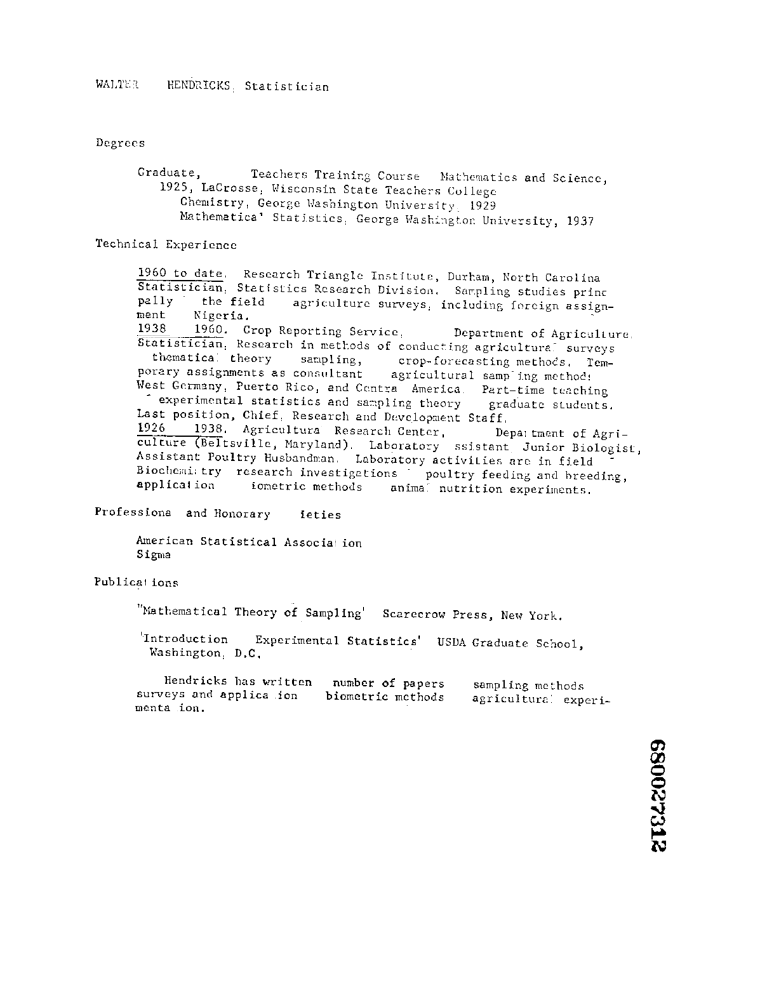

Labeling complete. Labels saved to: /content/drive/MyDrive/Machine learning  /labeled_image_prova.csv
Labeling interrupted. Labels saved to: /content/drive/MyDrive/Machine learning  /labeled_image_prova.csv


In [36]:
import cv2  # OpenCV for image processing
from google.colab.patches import cv2_imshow  # To display images in Google Colab
import os  # For file and directory operations
import pandas as pd  # For handling data in CSV format
import re  # For regular expressions to extract numbers from filenames
import ipywidgets as widgets  # For creating interactive UI elements
from IPython.display import display, clear_output  # For displaying UI elements and clearing output

# Define your image directory and output CSV file name
image_dir = "/content/drive/MyDrive/Machine learning  /resume-processed"
output_csv = '/content/drive/MyDrive/Machine learning  /labeled_image.csv'

# Get a list of image file paths from the directory and its subdirectories
all_images = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith('.tif'):  # Only include .tif files
            all_images.append(os.path.join(root, file))

# Function to extract numeric part from a filename
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else float('inf')  # Return a large number if no digits are found

# Sort the images by the extracted numeric part
all_images.sort(key=lambda x: extract_number(os.path.basename(x)))

# Container for labels
labels = []

def save_labels_to_csv(image_paths, labels, output_csv_path):
    """Save the labels to a CSV file."""
    df = pd.DataFrame(list(zip(image_paths, labels)), columns=['ImagePath', 'Label'])
    df.to_csv(output_csv_path, index=False)
    print("Labeling complete. Labels saved to:", output_csv_path)

# Create a dropdown widget for class selection
class_dropdown = widgets.Dropdown(
    options=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'],  # Define the classes
    description='Class:'  # Label for the dropdown
)

# Create buttons to submit the label and to quit
submit_button = widgets.Button(description="Submit")
quit_button = widgets.Button(description="Quit")

# Display the first image
current_index = 0

def display_next_image(index):
    img = cv2.imread(all_images[index])  # Read the image from the file
    if img is None:
        return  # Skip if the image can't be read
    cv2_imshow(img)  # Display the image in the notebook

# Function to handle submit button clicks
def on_submit_click(b):
    global current_index
    labels.append(class_dropdown.value)  # Save the selected class label
    current_index += 1
    if current_index < len(all_images[:500]):
        clear_output(wait=True)  # Clear the output to display the next image
        display(class_dropdown, submit_button, quit_button)
        display_next_image(current_index)  # Display the next image
    else:
        save_labels_to_csv(all_images[:500], labels, output_csv)  # Save labels to CSV if all images are labeled
        print("Labeling complete. Labels saved to:", output_csv)

# Function to handle quit button clicks
def on_quit_click(b):
    save_labels_to_csv(all_images[:current_index], labels, output_csv)  # Save labels to CSV before quitting
    print("Labeling interrupted. Labels saved to:", output_csv)
    clear_output(wait=True)  # Clear the output

# Attach the callback functions to the buttons
submit_button.on_click(on_submit_click)
quit_button.on_click(on_quit_click)

# Display the widgets and the first image
display(class_dropdown, submit_button, quit_button)
display_next_image(current_index)


### **Semi-supervised model with EfficientNetB0**

This script employs semi-supervised clustering to classify images, utilizing EfficientNetB0 for deep feature extraction alongside custom feature extraction techniques (LBP and HOG). The workflow encompasses data augmentation, dimensionality reduction with UMAP, and clustering via the COP-KMeans algorithm, which incorporates must-link and cannot-link constraints derived from labeled data. The clustering outcomes are saved into folders and a CSV file. Key evaluation metrics, including the silhouette score, Davies-Bouldin index, and Calinski-Harabasz index, are calculated to gauge clustering quality.

### Rationale for Semi-Supervised Clustering

Semi-supervised clustering is an effective approach when labeled data is scarce but unlabeled data is plentiful. By leveraging a small amount of labeled data to guide the clustering process, this method enhances accuracy compared to purely unsupervised techniques. The integration of must-link and cannot-link constraints helps in forming more meaningful and well-defined clusters, especially when there are clear relationships between certain data points.

### Cluster Weighting

In the COP-KMeans algorithm, additional weight was given to clusters 1 and 3. Cluster 1 is characterized by a complex layout made of several columns, while Cluster 3 typically contains a single box or very few elements. This specific weighting helps the algorithm prioritize these clusters during the clustering process, ensuring that their unique characteristics are more distinctly recognized and separated from other clusters.

### Code Explanation

- **Imports and Environment Setup**: The script imports necessary libraries and configures TensorFlow to use the CPU to avoid GPU-related issues.

- **Custom Feature Extraction**: The `custom_feature_extraction` function extracts Local Binary Pattern (LBP) and Histogram of Oriented Gradients (HOG) features from grayscale images.

- **Data Augmentation Setup**: The `ImageDataGenerator` is configured to augment the images with various transformations to increase the diversity of the training data.

- **Image Preprocessing**: The `preprocess_tiff_image` function resizes images to the required input size for EfficientNet, converts them to RGB if necessary, and applies data augmentation.

- **Feature Extraction**: The `extract_features` function combines deep features from EfficientNet and custom features (LBP and HOG) into a single feature vector.

- **EfficientNetB0 Model Setup**: An EfficientNetB0 model pretrained on ImageNet is used for deep feature extraction.

- **Load and Preprocess Images**: The `load_and_preprocess_images_from_folder` function loads and preprocesses images from a specified folder.

- **Save Clustered Images**: The `save_clusters_to_folders` function saves images into separate folders based on their cluster labels.

- **Save Clustering Results to CSV**: The `save_clusters_to_csv` function saves the clustering results into a CSV file with filenames and corresponding cluster labels.

- **COP-KMeans Algorithm**: The `cop_kmeans` function implements a COP-KMeans clustering algorithm that incorporates must-link and cannot-link constraints, as well as weights for specific clusters.

- **Folder Paths and Loading Labeled Data**: The paths to the image folder and labeled data CSV are defined, and the labeled data is loaded.

- **Preprocess All Images**: All images are loaded and preprocessed, and their features are extracted using both EfficientNet and custom feature extraction methods.

- **UMAP for Dimensionality Reduction**: UMAP is applied to reduce the dimensionality of the feature set, making it easier to visualize and cluster.

- **Create Constraints**: Must-link and cannot-link constraints are created based on the labeled data to guide the clustering process.

- **Apply COP-KMeans**: The COP-KMeans algorithm is applied with the specified constraints and weights to cluster the images.

- **Compute Evaluation Metrics**: The silhouette score, Davies-Bouldin index, and Calinski-Harabasz index are computed to evaluate the clustering quality.

- **Save Clustering Results**: The clustering results are saved into folders and a CSV file for further analysis and verification.

### Discussion of the Evaluation Metrics

#### Average Silhouette Score: 0.64

The silhouette score ranges from -1 to 1 and measures how similar an object is to its own cluster compared to other clusters. A score of 0.64 suggests that the clustering is reasonably well-defined. Values closer to 1 indicate that data points are well-clustered with clear separations between different clusters. Thus, a silhouette score of 0.64 indicates that the clustering has good cohesion and separation.

#### Average Davies-Bouldin Index: 5.01

The Davies-Bouldin index measures the average similarity ratio of each cluster with its most similar cluster. Lower values indicate better clustering, as it signifies that clusters are compact and well-separated from each other. A value of 5.01 is relatively high, suggesting some overlap between clusters or that clusters are not as compact as desired. This could be influenced by the human bias in the labeled data, where manual labeling decisions might not align perfectly with the feature extraction methods used.

#### Average Calinski-Harabasz Index: 6834.43

The Calinski-Harabasz index evaluates the ratio of between-cluster dispersion to within-cluster dispersion, with higher values indicating better-defined clusters. A score of 6834.43 is quite high, suggesting that the clusters are well-defined and there is significant separation between them. This high value aligns with the silhouette score, indicating overall good clustering quality.


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from skimage.feature import local_binary_pattern, hog
from skimage import color
import os
import shutil
import umap
import pandas as pd
from scipy.spatial.distance import cdist

# Ensure TensorFlow uses the CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

# Custom Feature Extraction using LBP and HOG
def custom_feature_extraction(image_array):
    gray_image = color.rgb2gray(image_array)
    lbp_features = local_binary_pattern(gray_image, P=24, R=3, method='uniform')
    lbp_hist, _ = np.histogram(lbp_features.ravel(), bins=np.arange(0, 24 + 3), range=(0, 24 + 2), density=True)

    hog_features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                          block_norm='L2-Hys', visualize=True)

    return np.hstack((lbp_hist, hog_features))

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocess images for EfficientNet
def preprocess_tiff_image(file_path, output_size=(299, 299)):
    with Image.open(file_path) as img:
        if img.mode == 'L' or img.mode == 'I':
            img = img.convert('RGB')
        img = img.resize(output_size, Image.Resampling.LANCZOS)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)  # Preprocess specific to EfficientNet

        # Apply data augmentation
        img_array = datagen.random_transform(img_array)

        return img_array

# Extract features using EfficientNet and custom features
def extract_features(img_array, model):
    expanded_img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(expanded_img_array)
    flattened_features = features.flatten()
    custom_features = custom_feature_extraction(img_array)
    return np.hstack((flattened_features, custom_features))

# Use EfficientNetB0 for feature extraction
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling='avg')

# Load and preprocess images from a folder
def load_and_preprocess_images_from_folder(folder, limit=None):
    features_list = []
    image_paths = []
    filenames = os.listdir(folder)
    if limit:
        filenames = filenames[:limit]
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        if img_path.lower().endswith('.tif'):
            img_array = preprocess_tiff_image(img_path)
            features = extract_features(img_array, model)
            features_list.append(features)
            image_paths.append(img_path)
    return features_list, image_paths

# Save clustered images to folders
def save_clusters_to_folders(cluster_labels, image_paths, output_folder, method_name):
    output_method_folder = os.path.join(output_folder, method_name)
    if not os.path.exists(output_method_folder):
        os.makedirs(output_method_folder)

    for cluster_num in np.unique(cluster_labels):
        cluster_folder = os.path.join(output_method_folder, f"Cluster_{cluster_num + 1}")
        if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)
        cluster_indices = np.where(cluster_labels == cluster_num)[0]
        for idx in cluster_indices:
            shutil.copy(image_paths[idx], cluster_folder)
        print(f"Cluster {cluster_num + 1} saved to {cluster_folder}")

# Save clustering results to a CSV file
def save_clusters_to_csv(cluster_labels, image_paths, output_folder, method_name):
    output_csv_path = os.path.join(output_folder, f"{method_name}_clusters.csv")
    data = {'filename': [os.path.basename(path) for path in image_paths], 'cluster': cluster_labels}
    df = pd.DataFrame(data)
    df.to_csv(output_csv_path, index=False)
    print(f"Clustering results saved to {output_csv_path}")

# COP-KMeans algorithm with weighting for specific clusters
def cop_kmeans(X, k, ml_constraints, cl_constraints, max_iter=300, weighted_clusters=None, weight_factor=0.5):
    def initialize_centroids(X, k):
        """ Initialize centroids by randomly selecting k unique points from X """
        indices = np.random.choice(X.shape[0], size=k, replace=False)
        return X[indices]

    def assign_clusters(X, centroids, ml_constraints, cl_constraints, weighted_clusters, weight_factor):
        """ Assign clusters to each point with constraints checking and weighted clusters """
        distances = cdist(X, centroids, 'euclidean')

        # Adjust distances for weighted clusters
        for cluster in weighted_clusters:
            distances[:, cluster] *= weight_factor

        labels = np.argmin(distances, axis=1)

        for (i, j) in ml_constraints:
            if labels[i] != labels[j]:
                if distances[i, labels[j]] < distances[j, labels[i]]:
                    labels[i] = labels[j]
                else:
                    labels[j] = labels[i]

        for (i, j) in cl_constraints:
            if labels[i] == labels[j]:
                if distances[i, labels[j]] < distances[j, labels[i]]:
                    labels[j] = (labels[j] + 1) % k
                else:
                    labels[i] = (labels[i] + 1) % k

        return labels

    def compute_centroids(X, labels, k):
        """ Compute new centroids as the mean of points in each cluster """
        centroids = np.zeros((k, X.shape[1]))
        for cluster in range(k):
            cluster_points = X[labels == cluster]
            if len(cluster_points) > 0:
                centroids[cluster] = cluster_points.mean(axis=0)
        return centroids

    centroids = initialize_centroids(X, k)
    labels = np.zeros(X.shape[0])

    for iteration in range(max_iter):
        new_labels = assign_clusters(X, centroids, ml_constraints, cl_constraints, weighted_clusters, weight_factor)
        if np.all(new_labels == labels):
            break
        labels = new_labels
        centroids = compute_centroids(X, labels, k)

    return labels

# Folder paths
folder_path = "/content/drive/MyDrive/Machine learning  /resume_black_boxes"
output_folder = "/content/drive/MyDrive/Machine learning  /clusters_supervised_model"

# Load labeled data
csv_path = "/content/drive/MyDrive/Machine learning  /labeled_images.csv"
labeled_data = pd.read_csv(csv_path, delimiter=';')

# Print the columns of the DataFrame to inspect them
print("Columns in the CSV file:", labeled_data.columns)

# Assuming the correct column names are 'image_path' and 'label'
labeled_image_paths = labeled_data['image_path'].tolist()
labeled_image_labels = labeled_data['label'].tolist()

# Extract filenames from labeled_image_paths
labeled_filenames = [os.path.basename(path) for path in labeled_image_paths]

# Load and preprocess all images
features_list, image_paths = load_and_preprocess_images_from_folder(folder_path)
features_list = np.array(features_list)

# Extract filenames from image_paths
image_filenames = [os.path.basename(path) for path in image_paths]

# Best UMAP parameters
best_umap_params = {
    'n_neighbors': 10,
    'min_dist': 0.1,
    'metric': 'cosine'
}

# Apply UMAP
umap_model = umap.UMAP(**best_umap_params, random_state=24)
features_reduced_umap = umap_model.fit_transform(features_list)

# Convert labeled data to indices in the dataset
labeled_indices = []
labeled_labels = []

# Ensure filenames are consistent
for filename in labeled_filenames:
    if filename in image_filenames:
        idx = image_filenames.index(filename)
        labeled_indices.append(idx)
        labeled_labels.append(labeled_image_labels[labeled_filenames.index(filename)])
    else:
        print(f"Warning: {filename} not found in image_filenames")

# Create constraints
n_samples = len(features_reduced_umap)
must_link_constraints = []
cannot_link_constraints = []

# Add must-link constraints
for i in range(len(labeled_indices)):
    for j in range(i + 1, len(labeled_indices)):
        if labeled_labels[i] == labeled_labels[j]:
            must_link_constraints.append((labeled_indices[i], labeled_indices[j]))

# Add cannot-link constraints
for i in range(len(labeled_indices)):
    for j in range(i + 1, len(labeled_indices)):
        if labeled_labels[i] != labeled_labels[j]:
            cannot_link_constraints.append((labeled_indices[i], labeled_indices[j]))

# Apply COP-KMeans with weights for clusters 1 and 3
weighted_clusters = [0, 2]  # Python is zero-indexed, so cluster 1 is index 0 and cluster 3 is index 2
weight_factor = 0.5
cluster_labels = cop_kmeans(features_reduced_umap, 5, must_link_constraints, cannot_link_constraints, weighted_clusters=weighted_clusters, weight_factor=weight_factor)

# Compute evaluation metrics
silhouette_avg = silhouette_score(features_reduced_umap, cluster_labels)
davies_bouldin_avg = davies_bouldin_score(features_reduced_umap, cluster_labels)
calinski_harabasz_avg = calinski_harabasz_score(features_reduced_umap, cluster_labels)

print(f"The average silhouette score is: {silhouette_avg:.2f}")
print(f"The average Davies-Bouldin index is: {davies_bouldin_avg:.2f}")
print(f"The average Calinski-Harabasz index is: {calinski_harabasz_avg:.2f}")

# Format the UMAP and KMeans parameter strings to be file-system friendly
umap_params_str = f"n_neighbors_{best_umap_params['n_neighbors']}min_dist{best_umap_params['min_dist']}metric{best_umap_params['metric']}".replace(' ', '').replace('{', '').replace('}', '').replace(':', '').replace(',', '').replace("'", "")
kmeans_params_str = f"n_clusters_5"

# Create a directory name that does not include unsupported characters
directory_name = f"clusters_semi-supervised_model"

# Use this directory name in the save_clusters_to_folders function
save_clusters_to_folders(cluster_labels, image_paths, output_folder, directory_name)

# Save clustering results to a CSV file
save_clusters_to_csv(cluster_labels, image_paths, output_folder, directory_name)


Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 116ms/step
The average silhouette score is: 0.64
The average Davies-Bouldin index is: 5.01
The average Calinski-Harabasz index is: 6834.43
Cluster 1 saved to /content/drive/MyDrive/Machine learning  /clusters_unsupervised_model/clusters_unsupervised_model/Cluster_1
Cluster 2 saved to /content/drive/MyDrive/Machine learning  /clusters_unsupervised_model/clusters_unsupervised_model/Cluster_2
Cluster 3 saved to /content/drive/MyDrive/Machine learning  /clusters_unsupervised_model/clusters_unsupervised_model/Cluster_3
Cluster 4 saved to /content/drive/MyDrive/Machine learning  /clusters_unsupervised_model/clusters_unsupervised_model/Cluster_4
Cluster 5 saved to /content/drive/MyDrive/Machine learning  /clusters_unsupervised_model/clusters_unsupervised_model/Cluster_5
Clustering results saved to /content/drive/MyDrive/Machine learning  /clusters_unsupervised_model/clusters_unsupervised_model_clusters

## **Third approach:Unsupervised model with BERT and LayoutLM**

In [6]:
import os
import pytesseract
from PIL import Image
from transformers import BertTokenizerFast, BertModel, LayoutLMTokenizer, LayoutLMModel
import torch
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from google.colab import drive
import logging
import shutil

# Suppress transformers logging
logging.getLogger("transformers").setLevel(logging.ERROR)

### Setting the folder path and batch size

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set up paths
folder_path = '/content/drive/MyDrive/Machine learning  /resume-processed'
output_folder_path = '/content/drive/MyDrive/Machine learning  /clusters_third_model'
limit = 1000  # limit of file to proces and cluster
batch_size = 1  # Increase batch size to better utilize GPU

### Checking if GPU device is available and use it

In [ ]:
# Check for CUDA device and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### Defining function to extract features from the images processed by denoiser

In this section, we define a function `extract_text_from_image` that utilizes Optical Character Recognition (OCR) to extract text from an image file.
The function takes an image file path as input, resizes the image to a standard width while maintaining the aspect ratio, and then applies OCR using the Tesseract library to extract and return the text content from the image.

The steps involved in the function are:
1. Open the image file.
2. Resize the image to a base width of 1000 pixels using the LANCZOS filter for high-quality downsampling.
3. Apply Tesseract OCR to the resized image to extract text.
4. Return the extracted text.

This preprocessing step ensures that the text in the images is readable and standardized for further analysis.


In [ ]:
def extract_text_from_image(image_path):
    # Open the image file
    img = Image.open(image_path)

    # Resizing the image to a base width of 1000 pixels while maintaining aspect ratio
    base_width = 1000
    w_percent = (base_width / float(img.size[0]))  # Calculate the width percentage
    h_size = int((float(img.size[1]) * float(w_percent)))  # Calculate the new height based on the width percentage
    img = img.resize((base_width, h_size), Image.LANCZOS)  # Resize the image using LANCZOS filter for high-quality downsampling

    # Perform OCR on the resized image to extract text
    text = pytesseract.image_to_string(img)

    # Return the extracted text
    return text

### Extract Text Features Using BERT

In this section, we define a function `extract_text_features` that utilizes a pre-trained BERT model to extract feature embeddings from a given text. The function takes the text, a tokenizer, and a model as input, tokenizes the text, processes it through the BERT model, and returns the feature embeddings.

The steps involved in the function are:
1. **Tokenize the Text**: The text is tokenized using the provided tokenizer with truncation and padding to ensure the input length is consistent and within the model's limits.
2. **Generate Input Tensors**: The tokenized inputs are converted to PyTorch tensors and moved to the appropriate device (CPU or GPU).
3. **Model Inference**: The BERT model processes the input tensors to generate output embeddings, with computations done in a `torch.no_grad()` context to avoid gradient calculation.
4. **Extract Features**: The function extracts the mean of the last hidden state embeddings from the model output, converts them to a numpy array, and returns the features.

This function is crucial for converting raw text into meaningful numerical representations (embeddings) that capture the semantic information of the text for further analysis.

#### Technical Details and Model Choice

**BERT (Bidirectional Encoder Representations from Transformers)**:
- **Architecture**: BERT uses a transformer-based architecture, specifically the encoder part of the transformer. It consists of multiple layers (12 in the base version) of bidirectional self-attention mechanisms, which allow it to consider both left and right context simultaneously.
- **Training**: BERT is pre-trained on a large corpus of text (e.g., Wikipedia, BookCorpus) using two unsupervised tasks: Masked Language Modeling (MLM) and Next Sentence Prediction (NSP). This pre-training enables BERT to capture deep contextual representations of language.
- **Tokenization**: BERT uses WordPiece tokenization, which breaks down words into subword units, allowing it to handle a large vocabulary efficiently and manage out-of-vocabulary words effectively.
- **Fine-tuning**: BERT can be fine-tuned for specific tasks with relatively small amounts of labeled data, leveraging its pre-trained knowledge to achieve state-of-the-art performance in various NLP tasks.

**Why BERT?**:
1. **Contextual Understanding**: BERT's bidirectional attention mechanism allows it to understand the context of a word based on its surrounding words, providing rich, contextual embeddings.
2. **Pre-trained Knowledge**: BERT's pre-training on vast amounts of text data makes it highly effective at capturing semantic nuances, even with limited labeled data for fine-tuning.
3. **Versatility**: BERT can be applied to a wide range of NLP tasks, including text classification, named entity recognition, and question answering, making it a versatile choice for feature extraction.
4. **State-of-the-art Performance**: BERT has consistently achieved state-of-the-art results on numerous NLP benchmarks, demonstrating its effectiveness in understanding and generating text representations.

By using BERT for text feature extraction, we leverage its ability to generate rich, contextual embeddings that capture the semantic meaning of the text, providing a strong foundation for subsequent analysis.

In [ ]:
def extract_text_features(text, tokenizer, model):
    # Tokenize the text with truncation and padding, and convert to PyTorch tensors
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)

    # Perform model inference without gradient calculation
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the mean of the last hidden state embeddings and convert to numpy array
    features = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

    return features

### Extract Layout Features Using LayoutLM

In this section, we define a function `extract_layout_features` that utilizes a pre-trained LayoutLM model to extract layout-aware feature embeddings from an image. The function takes an image file path, a tokenizer, and a model as input, processes the image to extract text and layout information, and returns the feature embeddings.

The steps involved in the function are:
1. **Open and Resize Image**: The image is opened and resized to a standard width while maintaining the aspect ratio to ensure text readability.
2. **Extract OCR Data**: Tesseract OCR is used to extract text and layout information (bounding boxes) from the image.
3. **Normalize Bounding Boxes**: The bounding boxes are normalized relative to the image dimensions.
4. **Tokenize Text and Layout Information**: The extracted text and bounding boxes are tokenized using the LayoutLM tokenizer with truncation and padding.
5. **Model Inference**: The LayoutLM model processes the input tensors to generate output embeddings, with computations done in a `torch.no_grad()` context.
6. **Extract Features**: The function extracts the mean of the last hidden state embeddings from the model output, converts them to a numpy array, and returns the features.

This function is crucial for capturing both textual and spatial information from document images, providing a comprehensive feature representation for further analysis.

#### Technical Details and Model Choice

**LayoutLM (Layout-Aware Language Model)**:
- **Architecture**: LayoutLM extends the BERT architecture by incorporating layout information. It uses the same transformer-based architecture but adds an additional input embedding for the spatial layout (bounding boxes) of the text.
- **Training**: LayoutLM is pre-trained on large-scale document datasets, learning to understand both text and its spatial arrangement. It uses tasks such as masked language modeling and structure-aware pre-training to capture the relationships between text and layout.
- **Tokenization**: LayoutLM uses a tokenizer similar to BERT but additionally requires bounding box coordinates for each token. These coordinates help the model understand the spatial structure of the document.
- **Fine-tuning**: LayoutLM can be fine-tuned for various document understanding tasks, such as form understanding, receipt parsing, and document classification, by leveraging its pre-trained knowledge of text and layout.

**Why LayoutLM?**:
1. **Text and Layout Integration**: LayoutLM captures both textual and spatial information, making it ideal for tasks where the layout of the text is crucial for understanding the document.
2. **Pre-trained on Document Data**: LayoutLM is pre-trained on a large corpus of documents, allowing it to generalize well to various document types and structures.
3. **Versatility**: LayoutLM can be fine-tuned for a wide range of document-related tasks, providing flexibility and robustness.
4. **State-of-the-art Performance**: LayoutLM has achieved state-of-the-art results on several document understanding benchmarks, demonstrating its effectiveness in capturing the interplay between text and layout.

By using LayoutLM for layout feature extraction, we leverage its ability to understand the spatial relationships between text elements, providing a comprehensive feature representation that includes both textual and layout information.

In [ ]:
def extract_layout_features(image_path, tokenizer, model):
    # Open the image and convert to RGB
    image = Image.open(image_path).convert("RGB")

    # Resizing the image to a base width of 1000 pixels while maintaining aspect ratio
    base_width = 1000
    w_percent = (base_width / float(image.size[0]))  # Calculate the width percentage
    h_size = int((float(image.size[1]) * float(w_percent)))  # Calculate the new height based on the width percentage
    image = image.resize((base_width, h_size), Image.LANCZOS)  # Resize the image using LANCZOS filter for high-quality downsampling
    width, height = image.size  # Get the new dimensions of the image

    words, boxes, actual_boxes = [], [], []

    # Use Tesseract to extract OCR data from the image
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    n_boxes = len(data['level'])  # Get the number of detected text elements

    for i in range(n_boxes):
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])  # Get the bounding box coordinates
        words.append(data['text'][i])  # Append the detected text
        boxes.append([x, y, x + w, y + h])  # Append the bounding box coordinates
        actual_boxes.append([x / width, y / height, (x + w) / width, (y + h) / height])  # Normalize the bounding boxes

    # Tokenize the words and bounding boxes
    encoded_inputs = tokenizer(
        words,
        boxes=actual_boxes,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        max_length=512  # Increase max_length to handle longer texts
    )
    encoded_inputs = {key: tensor.to(device) for key, tensor in encoded_inputs.items()}  # Move tensors to the appropriate device

    # Perform model inference without gradient calculation
    with torch.no_grad():
        outputs = model(**encoded_inputs)

    # Extract the mean of the last hidden state embeddings and convert to numpy array
    features = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

    return features


### Initialize Tokenizers and Models

In this section, we initialize the tokenizers and models for both text and layout feature extraction using pre-trained BERT and LayoutLM models. These models are loaded from the Hugging Face model hub and moved to the appropriate device (CPU or GPU).

The steps involved in this section are:
1. **Initialize BERT Tokenizer and Model**: Load the pre-trained BERT tokenizer and model for text feature extraction.
2. **Initialize LayoutLM Tokenizer and Model**: Load the pre-trained LayoutLM tokenizer and model for layout-aware feature extraction.
3. **Move Models to Device**: Move the models to the appropriate device (CPU or GPU) to leverage hardware acceleration for faster processing.

This setup ensures that we have the necessary tools for extracting both textual and spatial information from document images, providing a comprehensive feature representation for further analysis.


In [ ]:
# Initialize the BERT tokenizer and model for text feature extraction
text_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
text_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Initialize the LayoutLM tokenizer and model for layout feature extraction
layout_tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
layout_model = LayoutLMModel.from_pretrained("microsoft/layoutlm-base-uncased").to(device)


### Extract Features from All Images with Progress Tracking

In this section, we extract text and layout features from all images in the specified folder with progress tracking. The function processes each image to extract text and layout information, calculates the total number of words for a progress bar, and prepares the data for further analysis.

The steps involved in this section are:
1. **Initialize Lists for Features**: Create empty lists to store extracted texts, text features, and layout features.
2. **Print Extraction Message**: Inform the user that feature extraction is starting.
3. **Collect File Paths**: Gather all file paths of `.tif` images in the specified folder.
4. **Estimate Total Number of Words**: Calculate the total number of words to process for a progress bar:
   - **Initialize Total Words Counter**: Set up a counter to track the total number of words.
   - **Initialize Progress Bar**: Use `tqdm` to create a progress bar for tracking the estimation process.
   - **Process Each Image**: For each image, perform OCR to extract text elements and count the total number of words.

This setup ensures that we can monitor the progress of feature extraction and handle large datasets efficiently.


In [ ]:
# Initialize lists to store texts, text features, and layout features
texts = []
text_features = []
layout_features = []


print("Extracting features from images...")

# Initialize file count
file_count = 0

# Collect file paths for all .tif images in the specified folder
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tif')]

# Estimate total number of words to process for the progress bar
print("Estimating total number of words to process...")
total_words = 0

# Initialize the progress bar for word estimation
with tqdm(total=len(file_paths[:limit]), desc="Estimating words", unit="file", leave=False) as pbar:
    for file_path in file_paths[:limit]:
        # Open the image and convert to RGB
        data = pytesseract.image_to_data(Image.open(file_path).convert("RGB"), output_type=pytesseract.Output.DICT)

        # Sum up the number of detected text elements for word count
        total_words += len(data['text'])

        # Update the progress bar
        pbar.update(1)


### Process a Batch of Images

In this section, we define a function `process_batch` that processes a batch of image files to extract text, text features, and layout features. The function uses the previously defined functions for text extraction, text feature extraction using BERT, and layout feature extraction using LayoutLM. This approach allows for efficient batch processing, which is particularly useful when working with large datasets.

The steps involved in the function are:
1. **Extract Text from Each Image**: For each file in the batch, extract the text using OCR.
2. **Extract Text Features**: For each extracted text, compute the text features using the BERT model and tokenizer.
3. **Extract Layout Features**: For each file in the batch, compute the layout features using the LayoutLM model and tokenizer.
4. **Return Extracted Features**: Return the extracted texts, text features, and layout features for the batch.

This function helps in processing multiple images simultaneously, making the feature extraction process more efficient.


In [ ]:
def process_batch(batch_files):
    # Extract text from each image in the batch
    batch_texts = [extract_text_from_image(file_path) for file_path in batch_files]

    # Extract text features using BERT for each extracted text
    batch_text_features = [extract_text_features(text, text_tokenizer, text_model) for text in batch_texts]

    # Extract layout features using LayoutLM for each image in the batch
    batch_layout_features = [extract_layout_features(file_path, layout_tokenizer, layout_model) for file_path in batch_files]

    # Return the extracted texts, text features, and layout features
    return batch_texts, batch_text_features, batch_layout_features


 ### Process Files in Batches

In this section, we process the files in batches to extract and store text, text features, and layout features from each image. A progress bar is used to track the tokenization process, providing a visual indication of the progress. Additionally, memory is managed by clearing the cache after each batch is processed.

The steps involved in this section are:
1. **Initialize Progress Bar**: Create a progress bar to track the tokenization of images based on the total number of words estimated.
2. **Process Files in Batches**: Loop through the file paths in batches, processing a subset of files at a time.
3. **Extract Features**: For each batch, extract texts, text features, and layout features using the `process_batch` function.
4. **Store Extracted Features**: Append the extracted features to the respective lists for all files.
5. **Update Progress Bar**: Update the progress bar based on the number of words processed in each batch.
6. **Clear Cache**: Clear the cache and free up memory after processing each batch to ensure efficient memory usage.

This setup ensures that the feature extraction process is efficient and scalable, even for large datasets.

In [ ]:
# Process files in batches
with tqdm(total=total_words, desc="Tokenizing images", unit="word", leave=True) as pbar:
    for i in range(0, len(file_paths), batch_size):
        # Select the batch of files to process
        batch_files = file_paths[i:i+batch_size]

        # Process the batch to extract texts, text features, and layout features
        batch_texts, batch_text_features, batch_layout_features = process_batch(batch_files)

        # Store the extracted texts along with their file names
        texts.extend([(os.path.basename(file_path), text) for file_path, text in zip(batch_files, batch_texts)])

        # Store the extracted text and layout features
        text_features.extend(batch_text_features)
        layout_features.extend(batch_layout_features)

        # Update the progress bar based on the number of words processed in this batch
        pbar.update(len(batch_files) * 512)  # Assuming each file processes approximately 512 words

        # Clear cache after processing each batch to free up memory
        del batch_texts, batch_text_features, batch_layout_features
        torch.cuda.empty_cache()
        gc.collect()

        # Check if limit is reached
        file_count += len(batch_files)
        if file_count >= limit:
            break


### Calculate Maximum Feature Length

In this section, we calculate the maximum feature length from the extracted text and layout features. This is important for ensuring that all feature vectors have a consistent length, which is necessary for further processing such as clustering or dimensionality reduction.

In [ ]:
max_length = max([len(np.concatenate((np.squeeze(text_feat), np.squeeze(layout_feat).flatten()))) for text_feat, layout_feat in zip(text_features, layout_features)])

### Combine and Normalize Features with Padding or Truncating

In this section, we define a function `pad_or_truncate` to ensure that all feature vectors have a consistent length by either padding or truncating them to a fixed length. We then combine the text and layout features, apply the padding/truncating function, and convert the result into a NumPy array for further analysis.

The steps involved in this section are:
1. **Define Padding/Truncating Function**: Create a function to pad or truncate feature vectors to a specified length.
2. **Combine Features**: Concatenate text and layout features for each document.
3. **Apply Padding/Truncating**: Use the padding/truncating function to ensure all combined feature vectors have the same length.
4. **Store Combined Features**: Append the normalized feature vectors to a list and convert the list to a NumPy array.

This setup ensures that all feature vectors are of uniform length, which is crucial for machine learning algorithms that require fixed-length input vectors.


In [ ]:
# Function to pad or truncate features to a fixed length
def pad_or_truncate(feature, length):
    if len(feature) > length:
        return feature[:length]  # Truncate the feature if it's longer than the specified length
    elif len(feature) < length:
        return np.pad(feature, (0, length - len(feature)), 'constant')  # Pad the feature with zeros if it's shorter
    else:
        return feature  # Return the feature unchanged if it's already the specified length

# Combine text and layout features with padding or truncating
combined_features = []
for text_feat, layout_feat in zip(text_features, layout_features):
    text_feat = np.squeeze(text_feat)  # Remove single-dimensional entries from the shape of the text feature array
    layout_feat = np.squeeze(layout_feat).flatten()  # Flatten the layout feature array to ensure it's single-dimensional
    combined_feature = np.concatenate((text_feat, layout_feat))  # Concatenate text and layout features
    combined_feature = pad_or_truncate(combined_feature, max_length)  # Pad or truncate the combined feature to the max length
    combined_features.append(combined_feature)  # Append the normalized feature to the list

combined_features = np.array(combined_features)  # Convert the list of combined features to a NumPy array


### Plotting the PCA Elbow Curve

In this section, we define a function `plot_pca_elbow` to plot the explained variance as a function of the number of Principal Component Analysis (PCA) components.

This plot, often referred to as the "elbow plot," helps in determining the optimal number of PCA components to retain for capturing the most variance in the data.



In [ ]:
def plot_pca_elbow(data):
    pca = PCA().fit(data)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained')
    plt.title('Explained Variance by PCA Components')
    plt.grid(True)
    plt.show()

print("Plotting PCA elbow...")
plot_pca_elbow(combined_features)

Confirming the amount of PCA components suggested by the Elbow's plot and trasform the combined features in X components.

In [ ]:
# Reduce dimensionality using PCA
n_components = 1  # Adjust this based on the elbow plot
print(f"Reducing dimensionality to {n_components} components...")
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(combined_features)


### Finding the Optimal Number of Clusters

In this section, we define a function `find_optimal_clusters` to determine the best number of clusters for the data using the K-Means clustering algorithm.

 The function calculates the silhouette score for different numbers of clusters and plots the scores to help identify the optimal number.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Function to find the optimal number of clusters
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k + 1, 2)  # Range of cluster numbers to test
    s = []  # List to store silhouette scores for each cluster number
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)  # Fit KMeans model
        s.append(silhouette_score(data, kmeans.labels_))  # Compute silhouette score
        print(f'k: {k}, Silhouette Score: {s[-1]}')

    # Plot silhouette scores
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, s, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouette Score')
    ax.set_title('Silhouette Scores for Various Clusters')
    plt.show()

print("Finding the optimal number of clusters...")
find_optimal_clusters(X_reduced, 10)  # Call the function with the reduced data and max number of clusters


### Perform Clustering and Evaluate Results

In this section, we perform K-Means clustering on the reduced feature data using the optimal number of clusters determined from the silhouette analysis. We then evaluate the clustering results by calculating the silhouette score for the final clustering.


In [ ]:
# Perform clustering with the optimal number of clusters
optimal_clusters = 7  # Adjust this based on the silhouette analysis
print(f"Clustering into {optimal_clusters} clusters...")

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_reduced)  # Predict cluster labels for the data

# Evaluate the clustering results
score = silhouette_score(X_reduced, clusters)  # Calculate the silhouette score for the clustering
print(f'Silhouette Score: {score}')  # Print the silhouette score


### Saving the clusters result in different folders

In [ ]:
# Create directories for each cluster
for i in range(optimal_clusters):
    cluster_folder = os.path.join(output_folder_path, f'cluster_{i}')
    os.makedirs(cluster_folder, exist_ok=True)

# Copy files to respective cluster folders
for file_path, cluster in zip(file_paths, clusters):
    file_name = os.path.basename(file_path)
    cluster_folder = os.path.join(output_folder_path, f'cluster_{cluster}')
    if os.path.exists(file_path):
        shutil.copy(file_path, os.path.join(cluster_folder, file_name))
    else:
        print(f"File {file_path} not found, skipping.")

print(f"Files have been saved to {output_folder_path} in their respective cluster folders.")

# **Final versions of the clusters**

This code matches images between two folders and copies the matching images to an output folder, maintaining the original directory structure. This is done for the semi-supervised and unsupervised model in order to construct the final cleaned clusters.

### Code Explanation

**Import Libraries:**
- os for file and directory operations
- shutil for high-level file operations such as copying files.

**Match and Copy Images:**

- Function: match_and_copy_images(folder1, folder2, output_folder)
- Ensures the output folder exists by creating it if necessary.
- Walks through folder1, iterating over subdirectories and files.
- For each file, checks if it exists in folder2.
- If a match is found, determines the source path and the destination path.
- Copies the file from folder2 to the corresponding structure in the output folder.
- Prints a message indicating the success or failure of each file copy.

**Output Description**

The output of this code is a new folder (output_folder) containing copies of images that exist in both folder1 and folder2. The folder structure within the output folder mirrors that of folder1, ensuring that the hierarchical organization is maintained.



In [ ]:
import os
import shutil

def match_and_copy_images(folder1, folder2, output_folder):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for subdir, _, files in os.walk(folder1):
        # Calculate the relative path to create the corresponding structure in the output folder
        relative_path = os.path.relpath(subdir, folder1)
        target_subdir = os.path.join(output_folder, relative_path)
        os.makedirs(target_subdir, exist_ok=True)

        for file in files:
            # Check if the file exists in the second folder
            file_path_in_folder2 = os.path.join(folder2, file)
            if os.path.exists(file_path_in_folder2):
                # Determine the source path and the destination path
                src_path = file_path_in_folder2
                dest_path = os.path.join(target_subdir, file)

                try:
                    # Copy the file to the new folder structure
                    shutil.copy2(src_path, dest_path)
                    print(f"Copied {file} to {target_subdir}")
                except Exception as e:
                    print(f"Failed to copy {file} to {target_subdir}: {e}")


# Define the paths to your folders
folder1 = '/content/drive/MyDrive/Machine learning  /RESULTS SEMISUPERVISED'
folder2 = '/content/drive/MyDrive/Machine learning  /resume-processed'
output_folder = '/content/drive/MyDrive/Machine learning  /final_clusters_semisupervised'

# Call the function
match_and_copy_images(folder1, folder2, output_folder)


Copied cleaned_1009.tif to /content/drive/MyDrive/Machine learning  /final_clusters_semisupervised/clusters_semi-supervised_model/Cluster_1
Copied cleaned_1017.tif to /content/drive/MyDrive/Machine learning  /final_clusters_semisupervised/clusters_semi-supervised_model/Cluster_1
Copied cleaned_1018.tif to /content/drive/MyDrive/Machine learning  /final_clusters_semisupervised/clusters_semi-supervised_model/Cluster_1
Copied cleaned_1019.tif to /content/drive/MyDrive/Machine learning  /final_clusters_semisupervised/clusters_semi-supervised_model/Cluster_1
Copied cleaned_1020.tif to /content/drive/MyDrive/Machine learning  /final_clusters_semisupervised/clusters_semi-supervised_model/Cluster_1
Copied cleaned_1021.tif to /content/drive/MyDrive/Machine learning  /final_clusters_semisupervised/clusters_semi-supervised_model/Cluster_1
Copied cleaned_1022.tif to /content/drive/MyDrive/Machine learning  /final_clusters_semisupervised/clusters_semi-supervised_model/Cluster_1
Copied cleaned_104.t

KeyboardInterrupt: 

# **OCR**

## DnCNN


This script utilizes a Deep Convolutional Neural Network (DnCNN) to denoise images stored in a specified Google Drive folder.
The DnCNN model architecture, training, and validation were based on code from the "https://github.com/SaoYan/DnCNN-PyTorch" repository.

### Description

Image denoising is a critical preprocessing step in various computer vision tasks and applications, the DnCNN model is a state-of-the-art convolutional neural network specifically designed for image denoising. It leverages the power of deep learning to learn complex noise patterns and effectively remove them from images.

DnCNN stands out due to its use of residual learning and batch normalization. The residual learning strategy allows the network to focus on learning the noise component of the image rather than the clean image itself, making the denoising process more efficient. Batch normalization, on the other hand, helps in stabilizing and accelerating the training process by normalizing the input to each layer. This combination results in a powerful denoising model that can handle various types of noise.

DnCNN is an effective deep learning model for image denoising, leveraging residual learning and batch normalization to enhance performance and stability. By expanding the dataset with scanned documents and increasing the model's depth, the modified DnCNN model is better equipped to handle real-world noise patterns in scanned images. The early stopping mechanism based on PSNR ensures that the model training is efficient and prevents overfitting.

This script provides a comprehensive solution for denoising images, especially scanned documents, and can be easily adapted to other types of images and noise patterns. The use of PyTorch for model implementation and Google Colab for execution makes it accessible and convenient for users to deploy and experiment with the model on their datasets.

Modifications and Reasoning:
 1. *Dataset Augmentation*:
    - *Modification*: The training, test, and validation datasets were expanded to include 300 additional images, all of which are scanned documents.
    - *Reasoning*: Scanned documents often contain various types of noise such as speckles, blurs, and artifacts. By augmenting the dataset with these images, the model can better learn to handle and remove these specific noise types, improving its performance on similar real-world data.

 2. *Model Architecture*:
   - *Modification*: The number of layers in the DnCNN model was increased to 20.
   - *Reasoning*: Increasing the number of layers allows the model to capture more complex features and patterns in the images. This is particularly useful for denoising tasks where noise patterns can be intricate. A deeper network can potentially lead to better denoising performance by learning more sophisticated representations.

 3. *Early Stopping*:
    - *Modification*: The training process was modified to stop when the Peak Signal-to-Noise Ratio (PSNR) does not improve further, instead of running for a fixed number of epochs.
    - *Reasoning*: PSNR is a widely used metric for assessing the quality of image reconstruction. By stopping the training when PSNR does not improve, we prevent overfitting and ensure that the model maintains its generalization ability. This approach also saves computational resources by not running unnecessary epochs once the model has converged.

The resulting trained model is saved at the following path on Google Drive:
    - model_path = '/content/drive/MyDrive/Machine learning/best_model.pth'

### Steps and Explanation

1. Imports and Setup:
   - Libraries:
     - torch: For tensor operations and building neural networks.
     - torch.nn: Subpackage for neural network layers and modules.
     - torchvision.transforms: Common image transformations for computer vision tasks.
     - PIL.Image: For image manipulation.
     - numpy: For numerical operations.
     - cv2: For image processing.
     - os: For directory operations.
     - google.colab.drive: For interacting with Google Drive in Colab.
   - Environment Configuration:
     - Load the model from Google Drive.
     - Set the model to evaluation mode to prepare for image denoising.

2. Define the DnCNN Model:
   - *DnCNN Class*:
     - Initialization:
       - Initializes the DnCNN model with the specified number of input channels and layers.
       - Adds convolutional, batch normalization, and ReLU layers to form the network.
     - Forward Pass:
       - Defines the forward pass to perform image denoising by subtracting the network output from the input image.

3. Model Initialization:
   - Initializes the model with 1 input channel (grayscale) and 20 layers.
   - Loads the pre-trained weights from the specified path in Google Drive.
   - Wraps the model with DataParallel for potential multi-GPU usage.

4. Image Transformation:
   - Defines a transformation pipeline to preprocess the images before feeding them into the model:
     - Converts images to grayscale.
     - Transforms images to tensors.
     - Normalizes images based on the mean and standard deviation used during training.

5. Image Processing:
   - *Image Loading and Preprocessing*:
     - Loads images from the specified folder.
     - Converts images to grayscale using OpenCV.
     - Transforms the images using the defined transformation pipeline.
   - *Denoising with DnCNN*:
     - Passes the transformed images through the DnCNN model.
     - Converts the denoised output back to a NumPy array and scales it to the 0-255 range.
   - *Output Statistics*:
     - Prints statistics (min, max, mean) of the denoised output for each image.

6. Saving Processed Images:
   - Converts the denoised images back to PIL format.
   - Saves the processed images to the specified output folder in Google Drive.

### Example Usage

To use this script, follow these steps:
1. Ensure your Google Drive is mounted in your Google Colab environment.
2. Adjust 'model_path' to the correct path of the pre-trained model file on Google Drive.
3. Specify the 'folder_path' to the folder containing the images to be denoised.
4. Specify the 'output_folder_path' for saving the processed images.
5. Run the script in the Google Colab environment.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import os
from google.colab import drive


# Define the DnCNN model class
class DnCNN(nn.Module):
    def _init_(self, channels, num_of_layers):
        super(DnCNN, self)._init_()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []

        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out

# Initialize the model
model = DnCNN(channels=1, num_of_layers=20)
model = torch.nn.DataParallel(model)

# Path to the model file on Google Drive
model_path = '/content/drive/MyDrive/Machine learning  /best_model.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Define the transformation - adjust according to how the model was trained (e.g., grayscale)
transform = transforms.Compose([
    transforms.Grayscale(),  # Use if the model is trained on grayscale images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust normalization factors as used in training
])

# Path to the folder containing images in Google Drive
folder_path = '/content/drive/MyDrive/Machine learning  /resume-processed'
output_folder_path = '/content/drive/MyDrive/Machine learning  /resume-cnn'

if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Iterate over images in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.tif', '.png', '.jpg', '.jpeg')):  # Check for image files
        file_path = os.path.join(folder_path, filename)

        # Load and process image
        image_cv = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image_cv is not None:
            # Convert back to PIL Image for consistency with your workflow
            image_pil = Image.fromarray(image_cv)

            # Transform the image to tensor
            input_tensor = transform(image_pil).unsqueeze(0)  # Add batch dimension

            # Process image with the DnCNN model
            with torch.no_grad():  # No need to track gradients
                output = model(input_tensor)

            # Convert the output tensor back to numpy array
            output_image = output.squeeze().cpu().detach().numpy()

            # Check output statistics
            print(f"Output Image Stats for {filename} - Min:", np.min(output_image), "Max:", np.max(output_image), "Mean:", np.mean(output_image))

            # Convert the output image to uint8
            output_image_uint8 = np.clip(output_image, 0, 1) * 255  # Scale to 0-255 and clip
            output_image_uint8 = output_image_uint8.astype(np.uint8)  # Convert to uint8

            # Convert the denoised image back to PIL Image to continue with PIL operations
            image_pil_output = Image.fromarray(output_image_uint8)

            # Save the final processed image
            image_pil_output.save(os.path.join(output_folder_path, 'processed_' + filename))
        else:
            print(f"Failed to load image {filename}.")

## OCR

This script processes images to extract text and evaluate the percentage of understandable words using OCR (Optical Character Recognition) with Tesseract. It compares the performance of OCR on original images versus those processed by a Denoising Convolutional Neural Network (DnCNN). The analysis is conducted on the first 10 images in each specified folder.

Dependencies:
- pytesseract
- OpenCV (cv2)
- NLTK (Natural Language Toolkit)
- os

The script utilizes several libraries: pytesseract for OCR, OpenCV for image preprocessing, and NLTK for natural language processing. The script also downloads the NLTK word list to validate the extracted text against a list of English words.

The main functionality of the script is divided into three parts:
1. *Text Extraction*: Uses Tesseract OCR to extract text from images. Preprocessing steps like grayscale conversion, thresholding (Otsu's method), and median blur are applied to improve OCR accuracy. Grayscale conversion simplifies the image by removing color information, thresholding binarizes the image to separate text from the background, and median blur reduces noise.
2. *Understandable Words Count*: Splits the extracted text into individual words and compares them against the NLTK word list to count the number of understandable words. This step helps in assessing the quality of OCR by checking how many of the extracted words are valid English words.
3. *Folder Processing*: Processes a limited number of images in a folder, extracts text, and calculates the percentage of understandable words. This part of the script handles the bulk processing of images and provides a quantitative measure of OCR performance.

The script evaluates the performance of OCR on images processed by DnCNN by comparing it with original images. This comparison helps determine the effectiveness of denoising in improving text extraction accuracy.

Functions:
- extract_text_from_image(image_path):
  Extracts text from an image using Tesseract OCR.
  This function takes the path to an image file, loads the image using OpenCV, converts it to grayscale, applies preprocessing techniques (thresholding and median blur) to improve OCR accuracy, and then uses Tesseract to extract text from the preprocessed image.

- count_understandable_words(text):
  Counts the number of understandable words in the extracted text.
  This function takes the extracted text, splits it into individual words, compares each word against a list of English words from the NLTK corpus, and returns the count of understandable words and the total number of words.

- process_folder(folder_path, limit=10):
  Processes a limited number of images in a folder, extracts text, and calculates the percentage of understandable words.
  This function takes the path to a folder containing images, processes up to a specified limit of images by extracting text using Tesseract OCR, counting the understandable words, and calculating the percentage of understandable words in the extracted text. It returns the percentage of understandable words.

#### Results
Percentage of understandable words in folder 1: 31.03%

Percentage of understandable words in folder 3: 29.89%

In [ ]:
import pytesseract
from PIL import Image
import cv2
import numpy as np
from google.colab import drive
from nltk.corpus import words
import os
import nltk

# Download the word list
nltk.download('words')

def extract_text_from_image(image_path):
    """
    Extracts text from an image using Tesseract OCR.

    Args:
    image_path (str): Path to the image file.

    Returns:
    str: The text extracted from the image.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply preprocessing to improve OCR accuracy
    gray_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    gray_image = cv2.medianBlur(gray_image, 3)

    # Perform OCR on the preprocessed image specifying the language as English
    text = pytesseract.image_to_string(gray_image, lang='eng')

    return text

def count_understandable_words(text):
    """
    Counts the number of understandable words in the extracted text.

    Args:
    text (str): The text extracted from the image.

    Returns:
    int: The count of understandable words.
    list: The list of understandable words.
    """
    # Get the list of English words
    english_words = set(words.words())

    words_list = text.split()
    understandable_words = [word for word in words_list if word.lower() in english_words]
    return len(understandable_words), len(words_list)

def process_folder(folder_path, limit=10):
    """
    Processes a limited number of images in a folder, extracts text, and calculates the percentage of understandable words.

    Args:
    folder_path (str): Path to the folder containing images.
    limit (int): The maximum number of images to process.

    Returns:
    float: The percentage of understandable words.
    """
    total_words = 0
    total_understandable_words = 0

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))]

    for i, filename in enumerate(image_files[:limit]):
        file_path = os.path.join(folder_path, filename)
        extracted_text = extract_text_from_image(file_path)
        understandable_word_count, word_count = count_understandable_words(extracted_text)
        total_understandable_words += understandable_word_count
        total_words += word_count

    if total_words == 0:
        return 0
    return (total_understandable_words / total_words) * 100

# Paths to the folders
folder_path1 = '/content/drive/MyDrive/Machine learning/og-cnn-resume/cnn'
folder_path3 = '/content/drive/MyDrive/Machine learning/resume-processed'

# Calculate the percentage of understandable words in each folder
percentage1 = process_folder(folder_path1, limit=10)
percentage3 = process_folder(folder_path3, limit=10)

print(f"Percentage of understandable words in folder 1: {percentage1:.2f}%")
print(f"Percentage of understandable words in folder 3: {percentage3:.2f}%")

This script processes an image to extract text and count the number of understandable words using OCR (Optical Character Recognition) with Tesseract. It evaluates different preprocessing methods and blur types to determine the best combination for OCR accuracy. The script uses concurrent processing to handle multiple image processing tasks in parallel.

Dependencies:
- pytesseract
- Pillow (PIL)
- OpenCV (cv2)
- NumPy
- Google Colab (drive)
- NLTK (Natural Language Toolkit)
- SpellChecker (pyspellchecker)
- textdistance
- concurrent.futures
- os

The script performs the following tasks:
1. Downloads the NLTK word list for English.
2. Defines functions to preprocess images, extract text, count and correct understandable words, and process image combinations.
3. Processes an image with different preprocessing methods and blur types, counts understandable words, and determines the best and second-best combinations based on the number of understandable words.

Functions:
- preprocess_image(image_path, method='threshold', blur_type=None):

  Preprocesses the image to improve OCR accuracy.
- extract_text_from_image(preprocessed_image):

  Extracts text from a preprocessed image using Tesseract OCR.
- count_and_correct_words(text, threshold=2):
  
  Counts the number of understandable words in the extracted text and corrects them if they are close to English words.

- process_image_combination(image_path, method, blur):

  Processes an image with a specific preprocessing method and blur type, extracts text, and counts understandable words.



The script will print the number of understandable words for each combination of preprocessing method and blur type. It will then print the best and second-best combinations based on the number of understandable words.

#### Output:
Method: threshold, Blur: none, Number of understandable words: 182

Method: threshold, Blur: gaussian, Number of understandable words: 172

Method: adaptive, Blur: none, Number of understandable words: 182

Method: adaptive, Blur: gaussian, Number of understandable words: 170

Method: adaptive, Blur: median, Number of understandable words: 177

Method: threshold, Blur: median, Number of understandable words: 182

Method: none, Blur: gaussian, Number of understandable words: 170

Method: none, Blur: median, Number of understandable words: 183

Method: none, Blur: none, Number of understandable words: 183

#### Best result:
Method: none, Blur: median, Number of understandable words: 183, Total words: 183

#### Second best result:
Method: none, Blur: none, Number of understandable words: 183, Total words: 183

In [ ]:
import pytesseract
from PIL import Image
import cv2
import numpy as np
from google.colab import drive
import nltk
from nltk.corpus import words
from spellchecker import SpellChecker
import textdistance
import concurrent.futures

# Download the word list
nltk.download('words')

def preprocess_image(image_path, method='threshold', blur_type=None):
    """
    Preprocesses the image to improve OCR accuracy.

    Args:
    image_path (str): Path to the image file.
    method (str): Preprocessing method ('threshold', 'adaptive', 'none').
    blur_type (str): Type of blur to apply ('median', 'gaussian', 'none').

    Returns:
    np.array: The preprocessed image.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply the selected preprocessing method
    if method == 'threshold':
        gray_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    elif method == 'adaptive':
        gray_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Apply the selected blur type
    if blur_type == 'median':
        gray_image = cv2.medianBlur(gray_image, 3)
    elif blur_type == 'gaussian':
        gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    return gray_image

def extract_text_from_image(preprocessed_image):
    """
    Extracts text from a preprocessed image using Tesseract OCR.

    Args:
    preprocessed_image (np.array): The preprocessed image.

    Returns:
    str: The text extracted from the image.
    """
    # Perform OCR on the preprocessed image specifying the language as English
    text = pytesseract.image_to_string(preprocessed_image, lang='eng')
    return text

def count_and_correct_words(text, threshold=2):
    """
    Counts the number of understandable words in the extracted text
    and corrects them if they are close to English words.

    Args:
    text (str): The text extracted from the image.
    threshold (int): The Levenshtein distance threshold for correcting words.

    Returns:
    int: The count of understandable words.
    int: The count of total words.
    list: The list of corrected understandable words.
    """
    # Initialize spell checker and get the list of English words
    spell = SpellChecker()
    english_words = set(words.words())

    words_list = text.split()
    understandable_words = []

    for word in words_list:
        if word:
            # Check if the word is already a correct English word
            if word.lower() in english_words:
                understandable_words.append(word)
            else:
                # Check the most likely correction for the word
                correction = spell.correction(word)
                if correction:
                    # Check the Levenshtein distance between the word and its correction
                    distance = textdistance.levenshtein.distance(word, correction)
                    if distance <= threshold:
                        understandable_words.append(correction)
                    else:
                        understandable_words.append(word)
                else:
                    understandable_words.append(word)

    return len(understandable_words), len(words_list), understandable_words

def process_image_combination(image_path, method, blur):
    """
    Processes an image with a specific preprocessing method and blur type,
    extracts text, and counts understandable words.

    Args:
    image_path (str): Path to the image file.
    method (str): Preprocessing method.
    blur (str): Blur type.

    Returns:
    tuple: Processed result including counts and extracted text.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path, method, blur)

    # Extract text from the preprocessed image
    extracted_text = extract_text_from_image(preprocessed_image)

    # Count understandable words in the extracted text
    count, total_words, _ = count_and_correct_words(extracted_text)

    return (count, total_words, method, blur)

# Path to the image
image_path1 = '/content/drive/MyDrive/Machine learning/og-cnn-resume/cnn/processed_cleaned_1.tif'

# Define preprocessing methods and blur types
preprocessing_methods = ['threshold', 'adaptive', 'none']
blur_types = ['median', 'gaussian', 'none']

# Store results
results = []

# Use concurrent.futures for parallel processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for method in preprocessing_methods:
        for blur in blur_types:
            futures.append(executor.submit(process_image_combination, image_path1, method, blur))

    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        results.append((result[0], result[2], result[3], result[1]))
        print(f"Method: {result[2]}, Blur: {result[3]}, Number of understandable words: {result[0]}")

# Sort results by the count of understandable words
results.sort(reverse=True, key=lambda x: x[0])

# Get the best and second best results
best_result = results[0]
second_best_result = results[1]

# Print the best result
print("\nBest result:")
print(f"Method: {best_result[1]}, Blur: {best_result[2]}, Number of understandable words: {best_result[0]}, Total words: {best_result[3]}")

# Print the second best result
print("\nSecond best result:")
print(f"Method: {second_best_result[1]}, Blur: {second_best_result[2]}, Number of understandable words: {second_best_result[0]}, Total words: {second_best_result[3]}")

This script processes images to extract and correct text, then counts the number of understandable words using OCR (Optical Character Recognition) with Tesseract. It leverages the SymSpell library for spelling correction and NLTK's word list to identify understandable words. The results are saved in a JSON file.

### Dependencies:

- SymSpell
- pytesseract
- PIL (Python Imaging Library)
- OpenCV (cv2)
- NumPy
- NLTK (Natural Language Toolkit)
- os
- json

### The script performs the following tasks:
The script then processes all .tif files in the specified folder by applying these functions to each image. This involves preprocessing each image, extracting the text, correcting the text, and counting the understandable words. Finally, it compiles the results, including the counts of extracted and understandable words along with the corresponding texts, and saves them to a JSON file for further analysis. This detailed and systematic approach ensures that the extracted text is as accurate and meaningful as possible.

Functions:
- initialize_symspell():

  Initializes and loads dictionaries into SymSpell.

- preprocess_image(image_path):

  Preprocesses images to enhance OCR accuracy by converting to grayscale and applying thresholding.

- extract_text_from_image(preprocessed_image, custom_config):

  Extracts text from the preprocessed image using Tesseract OCR with a specified configuration.

- correct_ngrams(text, sym_spell):

  Corrects spelling errors in the extracted text using SymSpell, focusing on bigram corrections.

- count_and_correct_words(text, sym_spell):
  Corrects the extracted text, counts understandable words using NLTK's word list, and returns the count along with the corrected text.

- process_image(image_path, custom_config, sym_spell):
Orchestrates the preprocessing, text extraction, and word counting steps for a given image.

#### Output:
The script processes all .tif files in the specified folder, extracting and correcting text from each image. The results, including the counts of extracted and understandable words, and the corresponding texts, are saved to a JSON file for further use.

In [ ]:
# Import required libraries
from symspellpy import SymSpell, Verbosity
import pytesseract
from PIL import Image
import cv2
import numpy as np
import nltk
from nltk.corpus import words
import os
import json

# Download the word list
nltk.download('words')

def initialize_symspell():
    max_edit_distance_dictionary = 4
    prefix_length = 7
    sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

    # Load dictionary
    dictionary_path = "frequency_dictionary_en_82_765.txt"
    bigram_path = "frequency_bigramdictionary_en_243_342.txt"
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

    return sym_spell

sym_spell = initialize_symspell()

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return gray_image

def extract_text_from_image(preprocessed_image, custom_config):
    text = pytesseract.image_to_string(preprocessed_image, config=custom_config, lang='eng')
    return text

def correct_ngrams(text, sym_spell):
    words = text.split()
    corrected_text = []
    i = 0
    while i < len(words):
        word = words[i]
        if i < len(words) - 1:
            bigram = f"{word} {words[i+1]}"
            suggestions = sym_spell.lookup_compound(bigram, max_edit_distance=2)
            if suggestions:
                corrected_text.append(suggestions[0].term)
                i += 2  # Skip the next word as it is part of the bigram
                continue
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_text.append(suggestions[0].term)
        else:
            corrected_text.append(word)
        i += 1
    return ' '.join(corrected_text)

def count_and_correct_words(text, sym_spell):
    corrected_text = correct_ngrams(text, sym_spell)
    words_list = corrected_text.split()
    english_words = set(words.words())
    understandable_words = [word for word in words_list if word.lower() in english_words]
    return len(understandable_words), len(words_list), ' '.join(understandable_words)

def process_image(image_path, custom_config, sym_spell):
    preprocessed_image = preprocess_image(image_path)
    extracted_text = extract_text_from_image(preprocessed_image, custom_config)
    count, total_words, understandable_text = count_and_correct_words(extracted_text, sym_spell)
    return (count, extracted_text, understandable_text, total_words)

# Define paths
folder_path = '/content/drive/MyDrive/Machine learning  /resume-cnn'
json_path = '/content/drive/MyDrive/Machine learning  /ocr_results'

# Custom Tesseract OCR configuration
custom_config = '--oem 3 --psm 6'

# Initialize result dictionary
results = {}

# Process all .tif files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.tif'):
        image_path = os.path.join(folder_path, filename)
        result = process_image(image_path, custom_config, sym_spell)
        results[filename] = {
            'extracted_words_count': result[3],
            'understandable_words_count': result[0],
            'text_extracted': result[1],
            'text_understandable': result[2]
        }

# Save results to a JSON file
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

print(f"Results have been saved to {json_path}")
